## Import libraries

In [94]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import tensorflow as tf

sess = tf.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6936087779982653188
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15479354003835828224
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16465708939234090499
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12733425438563489461
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17463928833785536185
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10196962298306618806
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_ty

In [95]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas
import os
import warnings
import sklearn.utils
from copy import deepcopy
from PIL import Image
from bs4 import BeautifulSoup
import time
import csv
import random
import sys
import pickle
from tqdm import tqdm, trange
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger

import keras.backend as K
from keras.engine.topology import InputSpec
from keras.engine.topology import Layer
from keras.layers import Input, Lambda, Activation,SeparableConv2D, Conv2D, MaxPooling2D, ZeroPadding2D, Reshape, Concatenate
from keras.layers import Dropout,BatchNormalization,GaussianDropout,Flatten
from keras.models import Sequential, Model


from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.models import load_model
from math import ceil


#from keras_ssd300 import ssd_300
#from keras_ssd_loss import SSDLoss
#from keras_layer_AnchorBoxes import AnchorBoxes
#from keras_layer_L2Normalization import L2Normalization
#from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
#from ssd_batch_generator import BatchGenerator

%matplotlib inline

# DATA

'/home/purva/Desktop/purva/Single_shot_detector'

In [97]:
VOC_2007_images_dir      = "./VOC2007/JPEGImages/"
VOC_2007_test_images_dir = './VOC2007_Test/JPEGImages/'
VOC_2012_images_dir      = './VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = './VOC2007/Annotations/'
VOC_2007_test_annotations_dir = './VOC2007_Test/Annotations/'
VOC_2012_annotations_dir      = './VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = './VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = './VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = './VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = './VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = './VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = './VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = './VOC2007_Test/ImageSets/Main/test.txt'


In [98]:
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

# PAPER PARAMETERS

In [99]:
# The color channel order in the original SSD is BGR
# Number of positive classes, e.g. 20 for Pascal VOC
# The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
#Steps:  The space between two adjacent anchor box center points for each predictor layer.
#Offsets: # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
# limit_boxes: Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
#variances:  The variances by which the encoded target coordinates are scaled as in the original implementation
# coords=Whether the box coordinates to be used as targets for the model should be in the 'centroids', 'corners', or 'minmax' format, see documentation

In [100]:
img_height = 300 
img_width = 300 
img_channels = 3
subtract_mean = [123, 117, 104] 
swap_channels = True 
n_classes = 20 
scales= [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] 
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True

steps = [8, 16, 32, 64, 100, 300]
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
limit_boxes = False 
variances = [0.1, 0.1, 0.2, 0.2]
coords = 'centroids' 
normalize_coords = True

# PASCAL VOC DATASET

In [101]:
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

# MODEL VGG-16 modified for object detection

## Convert Coordinates

In [102]:
#Convert coordinates for axis-aligned 2D boxes between two coordinate formats.

#    Creates a copy of `tensor`, i.e. does not operate in place. Currently there are
#    three supported coordinate formats that can be converted from and to each other:
#        1) (xmin, xmax, ymin, ymax) - the 'minmax' format
#        2) (xmin, ymin, xmax, ymax) - the 'corners' format
#        3) (cx, cy, w, h) - the 'centroids' format

#    Note that converting from one of the supported formats to another and back is
#    an identity operation up to possible rounding errors for integer tensors.


In [103]:
def convert_coordinates(tensor, start_index, conversion):
    
    ind = start_index
    tensor1 = np.copy(tensor).astype(np.float)
    if conversion == 'minmax2centroids':
        tensor1[..., ind] = (tensor[..., ind] + tensor[..., ind+1]) / 2.0 # Set cx
        tensor1[..., ind+1] = (tensor[..., ind+2] + tensor[..., ind+3]) / 2.0 # Set cy
        tensor1[..., ind+2] = tensor[..., ind+1] - tensor[..., ind] # Set w
        tensor1[..., ind+3] = tensor[..., ind+3] - tensor[..., ind+2] # Set h
    elif conversion == 'centroids2minmax':
        tensor1[..., ind] = tensor[..., ind] - tensor[..., ind+2] / 2.0 # Set xmin
        tensor1[..., ind+1] = tensor[..., ind] + tensor[..., ind+2] / 2.0 # Set xmax
        tensor1[..., ind+2] = tensor[..., ind+1] - tensor[..., ind+3] / 2.0 # Set ymin
        tensor1[..., ind+3] = tensor[..., ind+1] + tensor[..., ind+3] / 2.0 # Set ymax
    elif conversion == 'corners2centroids':
        tensor1[..., ind] = (tensor[..., ind] + tensor[..., ind+2]) / 2.0 # Set cx
        tensor1[..., ind+1] = (tensor[..., ind+1] + tensor[..., ind+3]) / 2.0 # Set cy
        tensor1[..., ind+2] = tensor[..., ind+2] - tensor[..., ind] # Set w
        tensor1[..., ind+3] = tensor[..., ind+3] - tensor[..., ind+1] # Set h
    elif conversion == 'centroids2corners':
        tensor1[..., ind] = tensor[..., ind] - tensor[..., ind+2] / 2.0 # Set xmin
        tensor1[..., ind+1] = tensor[..., ind+1] - tensor[..., ind+3] / 2.0 # Set ymin
        tensor1[..., ind+2] = tensor[..., ind] + tensor[..., ind+2] / 2.0 # Set xmax
        tensor1[..., ind+3] = tensor[..., ind+1] + tensor[..., ind+3] / 2.0 # Set ymax
    elif (conversion == 'minmax2corners') or (conversion == 'corners2minmax'):
        tensor1[..., ind+1] = tensor[..., ind+2]
        tensor1[..., ind+2] = tensor[..., ind+1]
    else:
        raise ValueError("Unexpected conversion value. Supported values are 'minmax2centroids', 'centroids2minmax', 'corners2centroids', 'centroids2corners', 'minmax2corners', and 'corners2minmax'.")

    return tensor1



# HELPER FUNCTIONS

In [104]:
def iou(boxes1, boxes2, coords='centroids'):
    
    if len(boxes1.shape) == 1: boxes1 = np.expand_dims(boxes1, axis=0)
    if len(boxes2.shape) == 1: boxes2 = np.expand_dims(boxes2, axis=0)
    if coords == 'centroids':
        # TODO: Implement a version that uses fewer computation steps (that doesn't need conversion)
        boxes1 = convert_coordinates(boxes1, start_index=0, conversion='centroids2minmax')
        boxes2 = convert_coordinates(boxes2, start_index=0, conversion='centroids2minmax')
    elif not (coords in {'minmax', 'corners'}):
        raise ValueError("Unexpected value for `coords`. Supported values are 'minmax', 'corners' and 'centroids'.")

    if coords in {'minmax', 'centroids'}:
        intersection = np.maximum(0, np.minimum(boxes1[:,1], boxes2[:,1]) - np.maximum(boxes1[:,0], boxes2[:,0])) * np.maximum(0, np.minimum(boxes1[:,3], boxes2[:,3]) - np.maximum(boxes1[:,2], boxes2[:,2]))
        union = (boxes1[:,1] - boxes1[:,0]) * (boxes1[:,3] - boxes1[:,2]) + (boxes2[:,1] - boxes2[:,0]) * (boxes2[:,3] - boxes2[:,2]) - intersection
    elif coords == 'corners':
        intersection = np.maximum(0, np.minimum(boxes1[:,2], boxes2[:,2]) - np.maximum(boxes1[:,0], boxes2[:,0])) * np.maximum(0, np.minimum(boxes1[:,3], boxes2[:,3]) - np.maximum(boxes1[:,1], boxes2[:,1]))
        union = (boxes1[:,2] - boxes1[:,0]) * (boxes1[:,3] - boxes1[:,1]) + (boxes2[:,2] - boxes2[:,0]) * (boxes2[:,3] - boxes2[:,1]) - intersection

    return intersection / union

In [105]:
def convert_coordinates2(tensor, start_index, conversion):
    
    ind = start_index
    tensor1 = np.copy(tensor).astype(np.float)
    if conversion == 'minmax2centroids':
        M = np.array([[0.5, 0. , -1.,  0.],
                      [0.5, 0. ,  1.,  0.],
                      [0. , 0.5,  0., -1.],
                      [0. , 0.5,  0.,  1.]])
        tensor1[..., ind:ind+4] = np.dot(tensor1[..., ind:ind+4], M)
    elif conversion == 'centroids2minmax':
        M = np.array([[ 1. , 1. ,  0. , 0. ],
                      [ 0. , 0. ,  1. , 1. ],
                      [-0.5, 0.5,  0. , 0. ],
                      [ 0. , 0. , -0.5, 0.5]]) # The multiplicative inverse of the matrix above
        tensor1[..., ind:ind+4] = np.dot(tensor1[..., ind:ind+4], M)
    return tensor1

In [106]:
def greedy_nms(y_pred_decoded, iou_threshold=0.45, coords='corners'):
    y_pred_decoded_nms = []
    for batch_item in y_pred_decoded: # For the labels of each batch item...
        boxes_left = np.copy(batch_item)
        maxima = [] # This is where we store the boxes that make it through the non-maximum suppression
        while boxes_left.shape[0] > 0: # While there are still boxes left to compare...
            maximum_index = np.argmax(boxes_left[:,1]) # ...get the index of the next box with the highest confidence...
            maximum_box = np.copy(boxes_left[maximum_index]) # ...copy that box and...
            maxima.append(maximum_box) # ...append it to `maxima` because we'll definitely keep it
            boxes_left = np.delete(boxes_left, maximum_index, axis=0) # Now remove the maximum box from `boxes_left`
            if boxes_left.shape[0] == 0: break # If there are no boxes left after this step, break. Otherwise...
            similarities = iou(boxes_left[:,2:], maximum_box[2:], coords=coords) # ...compare (IoU) the other left over boxes to the maximum box...
            boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box
        y_pred_decoded_nms.append(np.array(maxima))

    return y_pred_decoded_nms


In [109]:
def _greedy_nms(predictions, iou_threshold=0.45, coords='corners'):
    '''
    The same greedy non-maximum suppression algorithm as above, but slightly modified for use as an internal
    function for per-class NMS in `decode_y()`.
    '''
    boxes_left = np.copy(predictions)
    maxima = [] # This is where we store the boxes that make it through the non-maximum suppression
    while boxes_left.shape[0] > 0: # While there are still boxes left to compare...
        maximum_index = np.argmax(boxes_left[:,0]) # ...get the index of the next box with the highest confidence...
        maximum_box = np.copy(boxes_left[maximum_index]) # ...copy that box and...
        maxima.append(maximum_box) # ...append it to `maxima` because we'll definitely keep it
        boxes_left = np.delete(boxes_left, maximum_index, axis=0) # Now remove the maximum box from `boxes_left`
        if boxes_left.shape[0] == 0: break # If there are no boxes left after this step, break. Otherwise...
        similarities = iou(boxes_left[:,1:], maximum_box[1:], coords=coords) # ...compare (IoU) the other left over boxes to the maximum box...
        boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box
    return np.array(maxima)

In [110]:
def _greedy_nms2(predictions, iou_threshold=0.45, coords='corners'):
    '''
    The same greedy non-maximum suppression algorithm as above, but slightly modified for use as an internal
    function in `decode_y2()`.
    '''
    boxes_left = np.copy(predictions)
    maxima = [] # This is where we store the boxes that make it through the non-maximum suppression
    while boxes_left.shape[0] > 0: # While there are still boxes left to compare...
        maximum_index = np.argmax(boxes_left[:,1]) # ...get the index of the next box with the highest confidence...
        maximum_box = np.copy(boxes_left[maximum_index]) # ...copy that box and...
        maxima.append(maximum_box) # ...append it to `maxima` because we'll definitely keep it
        boxes_left = np.delete(boxes_left, maximum_index, axis=0) # Now remove the maximum box from `boxes_left`
        if boxes_left.shape[0] == 0: break # If there are no boxes left after this step, break. Otherwise...
        similarities = iou(boxes_left[:,2:], maximum_box[2:], coords=coords) # ...compare (IoU) the other left over boxes to the maximum box...
        boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box
    return np.array(maxima)

## L2Normalization Layer

In [111]:
#Performs L2 normalization on the input tensor with a learnable scaling parameter
 #   as described in the paper "Parsenet: Looking Wider to See Better" (see references)
  #  and as used in the original SSD model.

In [112]:
class L2Normalization(Layer):
    def __init__(self, gamma_init=20, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.axis = 3
        else:
            self.axis = 1
        self.gamma_init = gamma_init
        super(L2Normalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        gamma = self.gamma_init * np.ones((input_shape[self.axis],))
        self.gamma = K.variable(gamma, name='{}_gamma'.format(self.name))
        self.trainable_weights = [self.gamma]
        super(L2Normalization, self).build(input_shape)

    def call(self, x, mask=None):
        output = K.l2_normalize(x, self.axis)
        output *= self.gamma
        return output

    def get_config(self):
        config = {
            'gamma_init': self.gamma_init
        }
        base_config = super(L2Normalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## AnchorBoxes

In [113]:
#A Keras layer to create an output tensor containing anchor box coordinates
#and variances based on the input tensor and the passed arguments.

#A set of 2D anchor boxes of different aspect ratios is created for each spatial unit of
#the input tensor. The number of anchor boxes created per unit depends on the arguments
#`aspect_ratios` and `two_boxes_for_ar1`, in the default case it is 4. The boxes
#are parameterized by the coordinate tuple `(xmin, xmax, ymin, ymax)`.



In [114]:
class AnchorBoxes(Layer):
    

    def __init__(self,
                 img_height,
                 img_width,
                 this_scale,
                 next_scale,
                 aspect_ratios=[0.5, 1.0, 2.0],
                 two_boxes_for_ar1=True,
                 this_steps=None,
                 this_offsets=None,
                 limit_boxes=True,
                 variances=[1.0, 1.0, 1.0, 1.0],
                 coords='centroids',
                 normalize_coords=False,
                 **kwargs):
        
        variances = np.array(variances)
        self.img_height = img_height
        self.img_width = img_width
        self.this_scale = this_scale
        self.next_scale = next_scale
        self.aspect_ratios = aspect_ratios
        self.two_boxes_for_ar1 = two_boxes_for_ar1
        self.this_steps = this_steps
        self.this_offsets = this_offsets
        self.limit_boxes = limit_boxes
        self.variances = variances
        self.coords = coords
        self.normalize_coords = normalize_coords
        # Compute the number of boxes per cell
        if (1 in aspect_ratios) and two_boxes_for_ar1:
            self.n_boxes = len(aspect_ratios) + 1
        else:
            self.n_boxes = len(aspect_ratios)
        super(AnchorBoxes, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(AnchorBoxes, self).build(input_shape)

    def call(self, x, mask=None):
        size = min(self.img_height, self.img_width)
        wh_list = []
        for ar in self.aspect_ratios:
            if (ar == 1):
                # Compute the regular anchor box for aspect ratio 1.
                box_height = box_width = self.this_scale * size
                wh_list.append((box_width, box_height))
                if self.two_boxes_for_ar1:
                    # Compute one slightly larger version using the geometric mean of this scale value and the next.
                    box_height = box_width = np.sqrt(self.this_scale * self.next_scale) * size
                    wh_list.append((box_width, box_height))
            else:
                box_height = self.this_scale * size / np.sqrt(ar)
                box_width = self.this_scale * size * np.sqrt(ar)
                wh_list.append((box_width, box_height))
        wh_list = np.array(wh_list)

        # We need the shape of the input tensor
        if K.image_dim_ordering() == 'tf':
            batch_size, feature_map_height, feature_map_width, feature_map_channels = x._keras_shape
        else: # Not yet relevant since TensorFlow is the only supported backend right now, but it can't harm to have this in here for the future
            batch_size, feature_map_channels, feature_map_height, feature_map_width = x._keras_shape

        # Compute the grid of box center points. They are identical for all aspect ratios.

        # Compute the step sizes, i.e. how far apart the anchor box center points will be vertically and horizontally.
        if (self.this_steps is None):
            step_height = self.img_height / feature_map_height
            step_width = self.img_width / feature_map_width
        else:
            if isinstance(self.this_steps, (list, tuple)) and (len(self.this_steps) == 2):
                step_height = self.this_steps[0]
                step_width = self.this_steps[1]
            elif isinstance(self.this_steps, (int, float)):
                step_height = self.this_steps
                step_width = self.this_steps
        # Compute the offsets, i.e. at what pixel values the first anchor box center point will be from the top and from the left of the image.
        if (self.this_offsets is None):
            offset_height = 0.5
            offset_width = 0.5
        else:
            if isinstance(self.this_offsets, (list, tuple)) and (len(self.this_offsets) == 2):
                offset_height = self.this_offsets[0]
                offset_width = self.this_offsets[1]
            elif isinstance(self.this_offsets, (int, float)):
                offset_height = self.this_offsets
                offset_width = self.this_offsets
        # Now that we have the offsets and step sizes, compute the grid of anchor box center points.
        cy = np.linspace(offset_height * step_height, (offset_height + feature_map_height - 1) * step_height, feature_map_height)
        cx = np.linspace(offset_width * step_width, (offset_width + feature_map_width - 1) * step_width, feature_map_width)
        cx_grid, cy_grid = np.meshgrid(cx, cy)
        cx_grid = np.expand_dims(cx_grid, -1) # This is necessary for np.tile() to do what we want further down
        cy_grid = np.expand_dims(cy_grid, -1) # This is necessary for np.tile() to do what we want further down

        # Create a 4D tensor template of shape `(feature_map_height, feature_map_width, n_boxes, 4)`
        # where the last dimension will contain `(cx, cy, w, h)`
        boxes_tensor = np.zeros((feature_map_height, feature_map_width, self.n_boxes, 4))

        boxes_tensor[:, :, :, 0] = np.tile(cx_grid, (1, 1, self.n_boxes)) # Set cx
        boxes_tensor[:, :, :, 1] = np.tile(cy_grid, (1, 1, self.n_boxes)) # Set cy
        boxes_tensor[:, :, :, 2] = wh_list[:, 0] # Set w
        boxes_tensor[:, :, :, 3] = wh_list[:, 1] # Set h

        # Convert `(cx, cy, w, h)` to `(xmin, xmax, ymin, ymax)`
        boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='centroids2corners')

        # If `limit_boxes` is enabled, clip the coordinates to lie within the image boundaries
        if self.limit_boxes:
            x_coords = boxes_tensor[:,:,:,[0, 2]]
            x_coords[x_coords >= self.img_width] = self.img_width - 1
            x_coords[x_coords < 0] = 0
            boxes_tensor[:,:,:,[0, 2]] = x_coords
            y_coords = boxes_tensor[:,:,:,[1, 3]]
            y_coords[y_coords >= self.img_height] = self.img_height - 1
            y_coords[y_coords < 0] = 0
            boxes_tensor[:,:,:,[1, 3]] = y_coords

        # If `normalize_coords` is enabled, normalize the coordinates to be within [0,1]
        if self.normalize_coords:
            boxes_tensor[:, :, :, [0, 2]] /= self.img_width
            boxes_tensor[:, :, :, [1, 3]] /= self.img_height

        # TODO: Implement box limiting directly for `(cx, cy, w, h)` so that we don't have to unnecessarily convert back and forth.
        if self.coords == 'centroids':
            # Convert `(xmin, ymin, xmax, ymax)` back to `(cx, cy, w, h)`.
            boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='corners2centroids')
        elif self.coords == 'minmax':
            # Convert `(xmin, ymin, xmax, ymax)` to `(xmin, xmax, ymin, ymax).
            boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='corners2minmax')

        # Create a tensor to contain the variances and append it to `boxes_tensor`. This tensor has the same shape
        # as `boxes_tensor` and simply contains the same 4 variance values for every position in the last axis.
        variances_tensor = np.zeros_like(boxes_tensor) # Has shape `(feature_map_height, feature_map_width, n_boxes, 4)`
        variances_tensor += self.variances # Long live broadcasting
        # Now `boxes_tensor` becomes a tensor of shape `(feature_map_height, feature_map_width, n_boxes, 8)`
        boxes_tensor = np.concatenate((boxes_tensor, variances_tensor), axis=-1)

        # Now prepend one dimension to `boxes_tensor` to account for the batch size and tile it along
        # The result will be a 5D tensor of shape `(batch_size, feature_map_height, feature_map_width, n_boxes, 8)`
        boxes_tensor = np.expand_dims(boxes_tensor, axis=0)
        boxes_tensor = K.tile(K.constant(boxes_tensor, dtype='float32'), (K.shape(x)[0], 1, 1, 1, 1))

        return boxes_tensor

    def compute_output_shape(self, input_shape):
        if K.image_dim_ordering() == 'tf':
            batch_size, feature_map_height, feature_map_width, feature_map_channels = input_shape
        else: # Not yet relevant since TensorFlow is the only supported backend right now, but it can't harm to have this in here for the future
            batch_size, feature_map_channels, feature_map_height, feature_map_width = input_shape
        return (batch_size, feature_map_height, feature_map_width, self.n_boxes, 8)

    def get_config(self):
        config = {
            'img_height': self.img_height,
            'img_width': self.img_width,
            'this_scale': self.this_scale,
            'next_scale': self.next_scale,
            'aspect_ratios': list(self.aspect_ratios),
            'two_boxes_for_ar1': self.two_boxes_for_ar1,
            'limit_boxes': self.limit_boxes,
            'variances': list(self.variances),
            'coords': self.coords,
            'normalize_coords': self.normalize_coords
        }
        base_config = super(AnchorBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [115]:
def ssd_300(image_size,
            n_classes,
            l2_regularization=0.0005,
            min_scale=None,
            max_scale=None,
            scales=None,
            aspect_ratios_global=None,
            aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5]],
            two_boxes_for_ar1=True,
            steps=[8, 16, 32, 64, 100, 300],
            offsets=None,
            limit_boxes=False,
            variances=[0.1, 0.1, 0.2, 0.2],
            coords='centroids',
            normalize_coords=False,
            subtract_mean=[123, 117, 104],
            divide_by_stddev=None,
            swap_channels=True,
            return_predictor_sizes=False):
    
    n_predictor_layers = 6 # The number of predictor conv layers in the network is 6 for the original SSD300

    n_classes += 1 # Account for the background class.

    # Get a few exceptions out of the way first
    if aspect_ratios_global is None and aspect_ratios_per_layer is None:
        raise ValueError("`aspect_ratios_global` and `aspect_ratios_per_layer` cannot both be None. At least one needs to be specified.")
    if aspect_ratios_per_layer:
        if len(aspect_ratios_per_layer) != n_predictor_layers:
            raise ValueError("It must be either aspect_ratios_per_layer is None or len(aspect_ratios_per_layer) == {}, but len(aspect_ratios_per_layer) == {}.".format(n_predictor_layers, len(aspect_ratios_per_layer)))

    if (min_scale is None or max_scale is None) and scales is None:
        raise ValueError("Either `min_scale` and `max_scale` or `scales` need to be specified.")
    if scales:
        if len(scales) != n_predictor_layers+1:
            raise ValueError("It must be either scales is None or len(scales) == {}, but len(scales) == {}.".format(n_predictor_layers+1, len(scales)))
    else: # If no explicit list of scaling factors was passed, compute the list of scaling factors from `min_scale` and `max_scale`
        scales = np.linspace(min_scale, max_scale, n_predictor_layers+1)

    variances = np.array(variances)
    
    # Set the aspect ratios for each predictor layer. These are only needed for the anchor box layers.
    if aspect_ratios_per_layer:
        aspect_ratios = aspect_ratios_per_layer
    else:
        aspect_ratios = [aspect_ratios_global] * n_predictor_layers

    # Compute the number of boxes to be predicted per cell for each predictor layer.
    # We need this so that we know how many channels the predictor layers need to have.
    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1) # +1 for the second box for aspect ratio 1
            else:
                n_boxes.append(len(ar))
    else: # If only a global aspect ratio list was passed, then the number of boxes is the same for each predictor layer
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    l2_reg = l2_regularization

    # Input image format
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

    ### Build the actual network.

    x = Input(shape=(img_height, img_width, img_channels))

    # The following identity layer is only needed so that subsequent lambda layers can be optional.
    x1 = Lambda(lambda z: z,
                output_shape=(img_height, img_width, img_channels),
                name='idendity_layer')(x)
    if not (subtract_mean is None):
        x1 = Lambda(lambda z: z - np.array(subtract_mean),
                   output_shape=(img_height, img_width, img_channels),
                   name='input_mean_normalization')(x1)
    if not (divide_by_stddev is None):
        x1 = Lambda(lambda z: z / np.array(divide_by_stddev),
                   output_shape=(img_height, img_width, img_channels),
                   name='input_stddev_normalization')(x1)
    if swap_channels and (img_channels == 3):
        x1 = Lambda(lambda z: z[...,::-1],
                   output_shape=(img_height, img_width, img_channels),
                   name='input_channel_swap')(x1)

    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_1')(x1)
    conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_2')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)

    conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_1')(pool1)
    conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_2')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)

    conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_1')(pool2)
    conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_3')(conv3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)

    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_1')(pool3)
    conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3')(conv4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)

    conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_1')(pool4)
    conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_3')(conv5_2)
    pool5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='pool5')(conv5_3)

    fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc6')(pool5)

    fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7')(fc6)

    conv6_1 = Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_1')(fc7)
    conv6_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv6_padding')(conv6_1)
    conv6_2 = Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2')(conv6_1)

    conv7_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_1')(conv6_2)
    conv7_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv7_padding')(conv7_1)
    conv7_2 = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2')(conv7_1)

    conv8_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_1')(conv7_2)
    conv8_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2')(conv8_1)

    conv9_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_1')(conv8_2)
    conv9_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2')(conv9_1)

    # Feed conv4_3 into the L2 normalization layer
    conv4_3_norm = L2Normalization(gamma_init=20, name='conv4_3_norm')(conv4_3)

    ### Build the convolutional predictor layers on top of the base network

    # We precidt `n_classes` confidence values for each box, hence the confidence predictors have depth `n_boxes * n_classes`
    # Output shape of the confidence layers: `(batch, height, width, n_boxes * n_classes)`
    conv4_3_norm_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_conf')(conv4_3_norm)
    fc7_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(fc7)
    conv6_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv6_2)
    conv7_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv7_2)
    conv8_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(conv8_2)
    conv9_2_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_conf')(conv9_2)
    # We predict 4 box coordinates for each box, hence the localization predictors have depth `n_boxes * 4`
    # Output shape of the localization layers: `(batch, height, width, n_boxes * 4)`
    conv4_3_norm_mbox_loc = Conv2D(n_boxes[0] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_loc')(conv4_3_norm)
    fc7_mbox_loc = Conv2D(n_boxes[1] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_loc')(fc7)
    conv6_2_mbox_loc = Conv2D(n_boxes[2] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_loc')(conv6_2)
    conv7_2_mbox_loc = Conv2D(n_boxes[3] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_loc')(conv7_2)
    conv8_2_mbox_loc = Conv2D(n_boxes[4] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_loc')(conv8_2)
    conv9_2_mbox_loc = Conv2D(n_boxes[5] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_loc')(conv9_2)

    ### Generate the anchor boxes (called "priors" in the original Caffe/C++ implementation, so I'll keep their layer names)

    # Output shape of anchors: `(batch, height, width, n_boxes, 8)`
    conv4_3_norm_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],
                                             two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0], limit_boxes=limit_boxes,
                                             variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv4_3_norm_mbox_priorbox')(conv4_3_norm_mbox_loc)
    fc7_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],
                                    two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[1], this_offsets=offsets[1], limit_boxes=limit_boxes,
                                    variances=variances, coords=coords, normalize_coords=normalize_coords, name='fc7_mbox_priorbox')(fc7_mbox_loc)
    conv6_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[2], this_offsets=offsets[2], limit_boxes=limit_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv6_2_mbox_priorbox')(conv6_2_mbox_loc)
    conv7_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[3], this_offsets=offsets[3], limit_boxes=limit_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv7_2_mbox_priorbox')(conv7_2_mbox_loc)
    conv8_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[4], next_scale=scales[5], aspect_ratios=aspect_ratios[4],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[4], this_offsets=offsets[4], limit_boxes=limit_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv8_2_mbox_priorbox')(conv8_2_mbox_loc)
    conv9_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[5], next_scale=scales[6], aspect_ratios=aspect_ratios[5],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[5], this_offsets=offsets[5], limit_boxes=limit_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv9_2_mbox_priorbox')(conv9_2_mbox_loc)

    ### Reshape

    # Reshape the class predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, n_classes)`
    # We want the classes isolated in the last axis to perform softmax on them
    conv4_3_norm_mbox_conf_reshape = Reshape((-1, n_classes), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_conf)
    fc7_mbox_conf_reshape = Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
    conv6_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
    conv7_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
    conv8_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
    conv9_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv9_2_mbox_conf_reshape')(conv9_2_mbox_conf)
    # Reshape the box predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, 4)`
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    conv4_3_norm_mbox_loc_reshape = Reshape((-1, 4), name='conv4_3_norm_mbox_loc_reshape')(conv4_3_norm_mbox_loc)
    fc7_mbox_loc_reshape = Reshape((-1, 4), name='fc7_mbox_loc_reshape')(fc7_mbox_loc)
    conv6_2_mbox_loc_reshape = Reshape((-1, 4), name='conv6_2_mbox_loc_reshape')(conv6_2_mbox_loc)
    conv7_2_mbox_loc_reshape = Reshape((-1, 4), name='conv7_2_mbox_loc_reshape')(conv7_2_mbox_loc)
    conv8_2_mbox_loc_reshape = Reshape((-1, 4), name='conv8_2_mbox_loc_reshape')(conv8_2_mbox_loc)
    conv9_2_mbox_loc_reshape = Reshape((-1, 4), name='conv9_2_mbox_loc_reshape')(conv9_2_mbox_loc)
    # Reshape the anchor box tensors, yielding 3D tensors of shape `(batch, height * width * n_boxes, 8)`
    conv4_3_norm_mbox_priorbox_reshape = Reshape((-1, 8), name='conv4_3_norm_mbox_priorbox_reshape')(conv4_3_norm_mbox_priorbox)
    fc7_mbox_priorbox_reshape = Reshape((-1, 8), name='fc7_mbox_priorbox_reshape')(fc7_mbox_priorbox)
    conv6_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv6_2_mbox_priorbox_reshape')(conv6_2_mbox_priorbox)
    conv7_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv7_2_mbox_priorbox_reshape')(conv7_2_mbox_priorbox)
    conv8_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv8_2_mbox_priorbox_reshape')(conv8_2_mbox_priorbox)
    conv9_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv9_2_mbox_priorbox_reshape')(conv9_2_mbox_priorbox)

    ### Concatenate the predictions from the different layers

    # Axis 0 (batch) and axis 2 (n_classes or 4, respectively) are identical for all layer predictions,
    # so we want to concatenate along axis 1, the number of boxes per layer
    # Output shape of `mbox_conf`: (batch, n_boxes_total, n_classes)
    mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv4_3_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       conv9_2_mbox_conf_reshape])

    # Output shape of `mbox_loc`: (batch, n_boxes_total, 4)
    mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv4_3_norm_mbox_loc_reshape,
                                                     fc7_mbox_loc_reshape,
                                                     conv6_2_mbox_loc_reshape,
                                                     conv7_2_mbox_loc_reshape,
                                                     conv8_2_mbox_loc_reshape,
                                                     conv9_2_mbox_loc_reshape])

    # Output shape of `mbox_priorbox`: (batch, n_boxes_total, 8)
    mbox_priorbox = Concatenate(axis=1, name='mbox_priorbox')([conv4_3_norm_mbox_priorbox_reshape,
                                                               fc7_mbox_priorbox_reshape,
                                                               conv6_2_mbox_priorbox_reshape,
                                                               conv7_2_mbox_priorbox_reshape,
                                                               conv8_2_mbox_priorbox_reshape,
                                                               conv9_2_mbox_priorbox_reshape])

    # The box coordinate predictions will go into the loss function just the way they are,
    # but for the class predictions, we'll apply a softmax activation layer first
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)

    # Concatenate the class and box predictions and the anchors to one large predictions vector
    # Output shape of `predictions`: (batch, n_boxes_total, n_classes + 4 + 8)
    predictions = Concatenate(axis=2, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_priorbox])

    model = Model(inputs=x, outputs=predictions)

    if return_predictor_sizes:
        # Get the spatial dimensions (height, width) of the predictor conv layers, we need them to
        # be able to generate the default boxes for the matching process outside of the model during training.
        # Note that the original implementation performs anchor box matching inside the loss function. We don't do that.
        # Instead, we'll do it in the batch generator function.
        # The spatial dimensions are the same for the confidence and localization predictors, so we just take those of the conf layers.
        predictor_sizes = np.array([conv4_3_norm_mbox_conf._keras_shape[1:3],
                                     fc7_mbox_conf._keras_shape[1:3],
                                     conv6_2_mbox_conf._keras_shape[1:3],
                                     conv7_2_mbox_conf._keras_shape[1:3],
                                     conv8_2_mbox_conf._keras_shape[1:3],
                                     conv9_2_mbox_conf._keras_shape[1:3]])
        return model, predictor_sizes
    else:
        return model

# SSD Loss

In [116]:

class SSDLoss:

    
    def __init__(self,
                 neg_pos_ratio=3,
                 n_neg_min=0,
                 alpha=1.0):
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = n_neg_min
        self.alpha = alpha

    def smooth_L1_loss(self, y_true, y_pred):
        
        absolute_loss = tf.abs(y_true - y_pred)
        square_loss = 0.5 * (y_true - y_pred)**2
        l1_loss = tf.where(tf.less(absolute_loss, 1.0), square_loss, absolute_loss - 0.5)
        return tf.reduce_sum(l1_loss, axis=-1)

    def log_loss(self, y_true, y_pred):
        y_pred = tf.maximum(y_pred, 1e-15)
        log_loss = -tf.reduce_sum(y_true * tf.log(y_pred), axis=-1)
        return log_loss

    def compute_loss(self, y_true, y_pred):
        
        self.neg_pos_ratio = tf.constant(self.neg_pos_ratio)
        self.n_neg_min = tf.constant(self.n_neg_min)
        self.alpha = tf.constant(self.alpha)

        batch_size = tf.shape(y_pred)[0]
        n_boxes = tf.shape(y_pred)[1] 
        classification_loss = tf.to_float(self.log_loss(y_true[:,:,:-12], y_pred[:,:,:-12])) # Output shape: (batch_size, n_boxes)
        localization_loss = tf.to_float(self.smooth_L1_loss(y_true[:,:,-12:-8], y_pred[:,:,-12:-8])) # Output shape: (batch_size, n_boxes)
        negatives = y_true[:,:,0] 
        positives = tf.to_float(tf.reduce_max(y_true[:,:,1:-12], axis=-1)) 
        n_positive = tf.reduce_sum(positives)
        pos_class_loss = tf.reduce_sum(classification_loss * positives, axis=-1) # Tensor of shape (batch_size,)

        neg_class_loss_all = classification_loss * negatives
        n_neg_losses = tf.count_nonzero(neg_class_loss_all, dtype=tf.int32) 
        n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.to_int32(n_positive), self.n_neg_min), n_neg_losses)
        def f1():
            return tf.zeros([batch_size])
        def f2():
           
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])
            values, indices = tf.nn.top_k(neg_class_loss_all_1D, n_negative_keep, False)
            
            negatives_keep = tf.scatter_nd(tf.expand_dims(indices, axis=1), updates=tf.ones_like(indices, dtype=tf.int32), shape=tf.shape(neg_class_loss_all_1D)) # Tensor of shape (batch_size * n_boxes,)
            negatives_keep = tf.to_float(tf.reshape(negatives_keep, [batch_size, n_boxes])) # Tensor of shape (batch_size, n_boxes)
            neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1) # Tensor of shape (batch_size,)
            return neg_class_loss

        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)

        class_loss = pos_class_loss + neg_class_loss
        loc_loss = tf.reduce_sum(localization_loss * positives, axis=-1)

        total_loss = (class_loss + self.alpha * loc_loss) / tf.maximum(1.0, n_positive) 
        total_loss *= tf.to_float(batch_size)

        return total_loss

In [117]:
K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                limit_boxes=limit_boxes,
                variances=variances,
                coords=coords,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels)


In [118]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
idendity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           idendity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 300, 300, 3)  0           input_mean_normalization[0][0]   
__________________________________________________________________________________________________
conv1_1 (C

In [119]:
# load weights from one of the original trained models.

In [120]:
weights_path = 'vgg-16_ssd-fcn_ILSVRC-CLS-LOC.h5'

model.load_weights(weights_path, by_name=True)

sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)
model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

# DATA GENERATION

In [135]:
def _translate(image, horizontal=(0,40), vertical=(0,10)):
   
    rows,cols,ch = image.shape

    x = np.random.randint(horizontal[0], horizontal[1]+1)
    y = np.random.randint(vertical[0], vertical[1]+1)
    x_shift = random.choice([-x, x])
    y_shift = random.choice([-y, y])

    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    return cv2.warpAffine(image, M, (cols, rows)), x_shift, y_shift

In [136]:
def _flip(image, orientation='horizontal'):
    
    if orientation == 'horizontal':
        return cv2.flip(image, 1)
    else:
        return cv2.flip(image, 0)

In [137]:
def _scale(image, min=0.9, max=1.1):
    rows,cols,ch = image.shape
    scale = np.random.uniform(min, max)
    M = cv2.getRotationMatrix2D((cols/2,rows/2), 0, scale)
    return cv2.warpAffine(image, M, (cols, rows)), M, scale


In [138]:
def _brightness(image, min=0.5, max=2.0):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_br = np.random.uniform(min,max)
    mask = hsv[:,:,2] * random_br > 255
    v_channel = np.where(mask, 255, hsv[:,:,2] * random_br)
    hsv[:,:,2] = v_channel
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)


In [139]:
def _histogram_eq(image):
    image1 = np.copy(image)
    image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2HSV)
    image1[:,:,2] = cv2.equalizeHist(image1[:,:,2])
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1

# Batch Data Generator

'''
    A generator to generate batches of samples and corresponding labels indefinitely.
    Can shuffle the dataset consistently after each complete pass.
    Currently provides two methods to parse annotation data: A general-purpose CSV parser
    and an XML parser for the Pascal VOC datasets. If the annotations of your dataset are
    in a format that is not supported by these parsers, you could just add another parser
    method and still use this generator.
    Can perform image transformations for data conversion and data augmentation,
    for details please refer to the documentation of the `generate()` method.
    '''


In [144]:
class BatchGenerator:
    
    def __init__(self,
                 box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'],
                 filenames=None,
                 filenames_type='text',
                 images_dir=None,
                 labels=None,
                 image_ids=None):
        self.box_output_format = box_output_format
        if not filenames is None:
            if isinstance(filenames, (list, tuple)):
                self.filenames = filenames
            elif isinstance(filenames, str):
                with open(filenames, 'rb') as f:
                    if filenames_type == 'pickle':
                        self.filenames = pickle.load(f)
                    elif filenames_type == 'text':
                        self.filenames = [os.path.join(images_dir, line.strip()) for line in f]
                    else:
                        raise ValueError("`filenames_type` can be either 'text' or 'pickle'.")
            else:
                raise ValueError("`filenames` must be either a Python list/tuple or a string representing a filepath (to a pickled or text file). The value you passed is neither of the two.")
        else:
            self.filenames = []

        if not labels is None:
            if isinstance(labels, str):
                with open(labels, 'rb') as f:
                    self.labels = pickle.load(f)
            elif isinstance(labels, (list, tuple)):
                self.labels = labels
            else:
                raise ValueError("`labels` must be either a Python list/tuple or a string representing the path to a pickled file containing a list/tuple. The value you passed is neither of the two.")
        else:
            self.labels = None

        if not image_ids is None:
            if isinstance(image_ids, str):
                with open(image_ids, 'rb') as f:
                    self.image_ids = pickle.load(f)
            elif isinstance(image_ids, (list, tuple)):
                self.image_ids = image_ids
            else:
                raise ValueError("`image_ids` must be either a Python list/tuple or a string representing the path to a pickled file containing a list/tuple. The value you passed is neither of the two.")
        else:
            self.image_ids = None

    def parse_xml(self,
                  images_dirs,
                  image_set_filenames,
                  annotations_dirs=[],
                  classes=['background',
                           'aeroplane', 'bicycle', 'bird', 'boat',
                           'bottle', 'bus', 'car', 'cat',
                           'chair', 'cow', 'diningtable', 'dog',
                           'horse', 'motorbike', 'person', 'pottedplant',
                           'sheep', 'sofa', 'train', 'tvmonitor'],
                  include_classes = 'all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False):
        
        self.images_dirs = images_dirs
        self.annotations_dirs = annotations_dirs
        self.image_set_filenames = image_set_filenames
        self.classes = classes
        self.include_classes = include_classes

        # Erase data that might have been parsed before.
        self.filenames = []
        self.image_ids = []
        self.labels = []
        if not annotations_dirs:
            self.labels = None
            annotations_dirs = [None] * len(images_dirs)

        for images_dir, image_set_filename, annotations_dir in zip(images_dirs, image_set_filenames, annotations_dirs):
            # Read the image set file that so that we know all the IDs of all the images to be included in the dataset.
            with open(image_set_filename) as f:
                image_ids = [line.strip() for line in f] # Note: These are strings, not integers.
                self.image_ids += image_ids

            # Loop over all images in this dataset.
            for image_id in image_ids:

                filename = '{}'.format(image_id) + '.jpg'
                self.filenames.append(os.path.join(images_dir, filename))

                if not annotations_dir is None:
                    # Parse the XML file for this image.
                    with open(os.path.join(annotations_dir, image_id + '.xml')) as f:
                        soup = BeautifulSoup(f, 'xml')

                    folder = soup.folder.text # In case we want to return the folder in addition to the image file name. Relevant for determining which dataset an image belongs to.
                    #filename = soup.filename.text

                    boxes = [] # We'll store all boxes for this image here
                    objects = soup.find_all('object') # Get a list of all objects in this image

                    # Parse the data for each object
                    for obj in objects:
                        class_name = obj.find('name').text
                        class_id = self.classes.index(class_name)
                        # Check if this class is supposed to be included in the dataset
                        if (not self.include_classes == 'all') and (not class_id in self.include_classes): continue
                        pose = obj.pose.text
                        truncated = int(obj.truncated.text)
                        if exclude_truncated and (truncated == 1): continue
                        difficult = int(obj.difficult.text)
                        if exclude_difficult and (difficult == 1): continue
                        xmin = int(obj.bndbox.xmin.text)
                        ymin = int(obj.bndbox.ymin.text)
                        xmax = int(obj.bndbox.xmax.text)
                        ymax = int(obj.bndbox.ymax.text)
                        item_dict = {'folder': folder,
                                     'image_name': filename,
                                     'image_id': image_id,
                                     'class_name': class_name,
                                     'class_id': class_id,
                                     'pose': pose,
                                     'truncated': truncated,
                                     'difficult': difficult,
                                     'xmin': xmin,
                                     'ymin': ymin,
                                     'xmax': xmax,
                                     'ymax': ymax}
                        box = []
                        for item in self.box_output_format:
                            box.append(item_dict[item])
                        boxes.append(box)

                    self.labels.append(boxes)

        if ret:
            return self.filenames, self.labels, self.image_ids



    def generate(self,
                 batch_size=32,
                 shuffle=True,
                 train=True,
                 ssd_box_encoder=None,
                 returns={'processed_images', 'encoded_labels'},
                 convert_to_3_channels=True,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 max_crop_and_resize=False,
                 random_pad_and_resize=False,
                 random_crop=False,
                 crop=False,
                 resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.3,
                 subtract_mean=None,
                 divide_by_stddev=None,
                 swap_channels=False,
                 keep_images_without_gt=False):
        
        if shuffle: # Shuffle the data before we begin
            if (self.labels is None) and (self.image_ids is None):
                self.filenames = sklearn.utils.shuffle(self.filenames)
            elif (self.labels is None):
                self.filenames, self.image_ids = sklearn.utils.shuffle(self.filenames, self.image_ids)
            elif (self.image_ids is None):
                self.filenames, self.labels = sklearn.utils.shuffle(self.filenames, self.labels)
            else:
                self.filenames, self.labels, self.image_ids = sklearn.utils.shuffle(self.filenames, self.labels, self.image_ids)
        current = 0

        # Find out the indices of the box coordinates in the label data
        xmin = self.box_output_format.index('xmin')
        ymin = self.box_output_format.index('ymin')
        xmax = self.box_output_format.index('xmax')
        ymax = self.box_output_format.index('ymax')
        ios = np.amin([xmin, ymin, xmax, ymax]) # Index offset, we need this for the inverse coordinate transform indices.

        while True:

            batch_X, batch_y = [], []

            if current >= len(self.filenames):
                current = 0
                if shuffle:
                    # Shuffle the data after each complete pass
                    if (self.labels is None) and (self.image_ids is None):
                        self.filenames = sklearn.utils.shuffle(self.filenames)
                    elif (self.labels is None):
                        self.filenames, self.image_ids = sklearn.utils.shuffle(self.filenames, self.image_ids)
                    elif (self.image_ids is None):
                        self.filenames, self.labels = sklearn.utils.shuffle(self.filenames, self.labels)
                    else:
                        self.filenames, self.labels, self.image_ids = sklearn.utils.shuffle(self.filenames, self.labels, self.image_ids)

            # Get the image filepaths for this batch.
            batch_filenames = self.filenames[current:current+batch_size]

            # Load the images for this batch.
            for filename in batch_filenames:
                with Image.open(filename) as img:
                    batch_X.append(np.array(img))

            # Get the labels for this batch (if there are any).
            if not (self.labels is None):
                batch_y = deepcopy(self.labels[current:current+batch_size])
            else:
                batch_y = None

            # Get the image IDs for this batch (if there are any).
            if not self.image_ids is None:
                batch_image_ids = self.image_ids[current:current+batch_size]
            else:
                batch_image_ids = None

            # Create the array that is to contain the inverse coordinate transformation values for this batch.
            batch_inverse_coord_transform = np.array([[[0, 1]] * 4] * batch_size, dtype=np.float) # Array of shape `(batch_size, 4, 2)`, where the last axis contains an additive and a multiplicative scalar transformation constant.

            if 'original_images' in returns:
                batch_original_images = deepcopy(batch_X) # The original, unaltered images
            if 'original_labels' in returns and not batch_y is None:
                batch_original_labels = deepcopy(batch_y) # The original, unaltered labels

            current += batch_size

            batch_items_to_remove = [] # In case we need to remove any images from the batch because of failed random cropping, store their indices in this list.

            for i in range(len(batch_X)):

                img_height, img_width = batch_X[i].shape[0], batch_X[i].shape[1]

                if not batch_y is None:
                    # If this image has no ground truth boxes, maybe we don't want to keep it in the batch.
                    if (len(batch_y[i]) == 0) and not keep_images_without_gt:
                        batch_items_to_remove.append(i)
                    # Convert labels into an array (in case it isn't one already), otherwise the indexing below breaks.
                    batch_y[i] = np.array(batch_y[i])

                # From here on, perform some optional image transformations.

                if (batch_X[i].ndim == 2) and convert_to_3_channels:
                    # Convert the 1-channel image into a 3-channel image.
                    batch_X[i] = np.stack([batch_X[i]] * 3, axis=-1)

                if equalize:
                    batch_X[i] = histogram_eq(batch_X[i])

                if brightness:
                    p = np.random.uniform(0,1)
                    if p >= (1-brightness[2]):
                        batch_X[i] = _brightness(batch_X[i], min=brightness[0], max=brightness[1])

                if flip: # Performs flips along the vertical axis only (i.e. horizontal flips).
                    p = np.random.uniform(0,1)
                    if p >= (1-flip):
                        batch_X[i] = _flip(batch_X[i])
                        if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                            batch_y[i][:,[xmin,xmax]] = img_width - batch_y[i][:,[xmax,xmin]] # xmin and xmax are swapped when mirrored

                if translate:
                    p = np.random.uniform(0,1)
                    if p >= (1-translate[2]):
                        # Translate the image and return the shift values so that we can adjust the labels
                        batch_X[i], xshift, yshift = _translate(batch_X[i], translate[0], translate[1])
                        if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                            # Adjust the box coordinates.
                            batch_y[i][:,[xmin,xmax]] += xshift
                            batch_y[i][:,[ymin,ymax]] += yshift
                            # Limit the box coordinates to lie within the image boundaries
                            if limit_boxes:
                                before_limiting = deepcopy(batch_y[i])
                                x_coords = batch_y[i][:,[xmin,xmax]]
                                x_coords[x_coords >= img_width] = img_width - 1
                                x_coords[x_coords < 0] = 0
                                batch_y[i][:,[xmin,xmax]] = x_coords
                                y_coords = batch_y[i][:,[ymin,ymax]]
                                y_coords[y_coords >= img_height] = img_height - 1
                                y_coords[y_coords < 0] = 0
                                batch_y[i][:,[ymin,ymax]] = y_coords
                                # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                                # process that they don't serve as useful training examples anymore, because too little of them is
                                # visible. We'll remove all boxes that we had to limit so much that their area is less than
                                # `include_thresh` of the box area before limiting.
                                before_area = (before_limiting[:,xmax] - before_limiting[:,xmin]) * (before_limiting[:,ymax] - before_limiting[:,ymin])
                                after_area = (batch_y[i][:,xmax] - batch_y[i][:,xmin]) * (batch_y[i][:,ymax] - batch_y[i][:,ymin])
                                if include_thresh == 0: batch_y[i] = batch_y[i][after_area > include_thresh * before_area] # If `include_thresh == 0`, we want to make sure that boxes with area 0 get thrown out, hence the ">" sign instead of the ">=" sign
                                else: batch_y[i] = batch_y[i][after_area >= include_thresh * before_area] # Especially for the case `include_thresh == 1` we want the ">=" sign, otherwise no boxes would be left at all

                if scale:
                    p = np.random.uniform(0,1)
                    if p >= (1-scale[2]):
                        # Rescale the image and return the transformation matrix M so we can use it to adjust the box coordinates
                        batch_X[i], M, scale_factor = _scale(batch_X[i], scale[0], scale[1])
                        if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                            # Adjust the box coordinates.
                            # Transform two opposite corner points of the rectangular boxes using the transformation matrix `M`
                            toplefts = np.array([batch_y[i][:,xmin], batch_y[i][:,ymin], np.ones(batch_y[i].shape[0])])
                            bottomrights = np.array([batch_y[i][:,xmax], batch_y[i][:,ymax], np.ones(batch_y[i].shape[0])])
                            new_toplefts = (np.dot(M, toplefts)).T
                            new_bottomrights = (np.dot(M, bottomrights)).T
                            batch_y[i][:,[xmin,ymin]] = new_toplefts.astype(np.int)
                            batch_y[i][:,[xmax,ymax]] = new_bottomrights.astype(np.int)
                            # Limit the box coordinates to lie within the image boundaries
                            if limit_boxes and (scale_factor > 1): # We don't need to do any limiting in case we shrunk the image
                                before_limiting = deepcopy(batch_y[i])
                                x_coords = batch_y[i][:,[xmin,xmax]]
                                x_coords[x_coords >= img_width] = img_width - 1
                                x_coords[x_coords < 0] = 0
                                batch_y[i][:,[xmin,xmax]] = x_coords
                                y_coords = batch_y[i][:,[ymin,ymax]]
                                y_coords[y_coords >= img_height] = img_height - 1
                                y_coords[y_coords < 0] = 0
                                batch_y[i][:,[ymin,ymax]] = y_coords
                                # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                                # process that they don't serve as useful training examples anymore, because too little of them is
                                # visible. We'll remove all boxes that we had to limit so much that their area is less than
                                # `include_thresh` of the box area before limiting.
                                before_area = (before_limiting[:,xmax] - before_limiting[:,xmin]) * (before_limiting[:,ymax] - before_limiting[:,ymin])
                                after_area = (batch_y[i][:,xmax] - batch_y[i][:,xmin]) * (batch_y[i][:,ymax] - batch_y[i][:,ymin])
                                if include_thresh == 0: batch_y[i] = batch_y[i][after_area > include_thresh * before_area] # If `include_thresh == 0`, we want to make sure that boxes with area 0 get thrown out, hence the ">" sign instead of the ">=" sign
                                else: batch_y[i] = batch_y[i][after_area >= include_thresh * before_area] # Especially for the case `include_thresh == 1` we want the ">=" sign, otherwise no boxes would be left at all

                if max_crop_and_resize:
                    # The ratio of the two aspect ratios (source image and target size) determines the maximal possible crop.
                    image_aspect_ratio = img_width / img_height
                    resize_aspect_ratio = max_crop_and_resize[1] / max_crop_and_resize[0]

                    if image_aspect_ratio < resize_aspect_ratio:
                        crop_width = img_width
                        crop_height = int(round(crop_width / resize_aspect_ratio))
                    else:
                        crop_height = img_height
                        crop_width = int(round(crop_height * resize_aspect_ratio))
                    # The actual cropping and resizing will be done by the random crop and resizing operations below.
                    # Here, we only set the parameters for them.
                    random_crop = (crop_height, crop_width, max_crop_and_resize[2], max_crop_and_resize[3])
                    resize = (max_crop_and_resize[0], max_crop_and_resize[1])

                if random_pad_and_resize:

                    resize_aspect_ratio = random_pad_and_resize[1] / random_pad_and_resize[0]

                    if img_width < img_height:
                        crop_height = img_height
                        crop_width = int(round(crop_height * resize_aspect_ratio))
                    else:
                        crop_width = img_width
                        crop_height = int(round(crop_width / resize_aspect_ratio))
                    # The actual cropping and resizing will be done by the random crop and resizing operations below.
                    # Here, we only set the parameters for them.
                    if max_crop_and_resize:
                        p = np.random.uniform(0,1)
                        if p >= (1-random_pad_and_resize[4]):
                            random_crop = (crop_height, crop_width, random_pad_and_resize[2], random_pad_and_resize[3])
                            resize = (random_pad_and_resize[0], random_pad_and_resize[1])
                    else:
                        random_crop = (crop_height, crop_width, random_pad_and_resize[2], random_pad_and_resize[3])
                        resize = (random_pad_and_resize[0], random_pad_and_resize[1])

                if random_crop:
                    # Compute how much room we have in both dimensions to make a random crop.
                    # A negative number here means that we want to crop out a patch that is larger than the original image in the respective dimension,
                    # in which case we will create a black background canvas onto which we will randomly place the image.
                    y_range = img_height - random_crop[0]
                    x_range = img_width - random_crop[1]
                    # Keep track of the number of trials and of whether or not the most recent crop contains at least one object
                    min_1_object_fulfilled = False
                    trial_counter = 0
                    while (not min_1_object_fulfilled) and (trial_counter < random_crop[3]):
                        # Select a random crop position from the possible crop positions
                        if y_range >= 0: crop_ymin = np.random.randint(0, y_range + 1) # There are y_range + 1 possible positions for the crop in the vertical dimension
                        else: crop_ymin = np.random.randint(0, -y_range + 1) # The possible positions for the image on the background canvas in the vertical dimension
                        if x_range >= 0: crop_xmin = np.random.randint(0, x_range + 1) # There are x_range + 1 possible positions for the crop in the horizontal dimension
                        else: crop_xmin = np.random.randint(0, -x_range + 1) # The possible positions for the image on the background canvas in the horizontal dimension
                        # Perform the crop
                        if y_range >= 0 and x_range >= 0: # If the patch to be cropped out is smaller than the original image in both dimenstions, we just perform a regular crop
                            # Crop the image
                            patch_X = np.copy(batch_X[i][crop_ymin:crop_ymin+random_crop[0], crop_xmin:crop_xmin+random_crop[1]])
                            # Add the parameters to reverse this transformation.
                            patch_y_inverse_y = crop_ymin
                            patch_y_inverse_x = crop_xmin
                            if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                                # Translate the box coordinates into the new coordinate system: Cropping shifts the origin by `(crop_ymin, crop_xmin)`
                                patch_y = np.copy(batch_y[i])
                                patch_y[:,[ymin,ymax]] -= crop_ymin
                                patch_y[:,[xmin,xmax]] -= crop_xmin
                                # Limit the box coordinates to lie within the new image boundaries
                                if limit_boxes:
                                    # Both the x- and y-coordinates might need to be limited
                                    before_limiting = np.copy(patch_y)
                                    y_coords = patch_y[:,[ymin,ymax]]
                                    y_coords[y_coords < 0] = 0
                                    y_coords[y_coords >= random_crop[0]] = random_crop[0] - 1
                                    patch_y[:,[ymin,ymax]] = y_coords
                                    x_coords = patch_y[:,[xmin,xmax]]
                                    x_coords[x_coords < 0] = 0
                                    x_coords[x_coords >= random_crop[1]] = random_crop[1] - 1
                                    patch_y[:,[xmin,xmax]] = x_coords
                        elif y_range >= 0 and x_range < 0: # If the crop is larger than the original image in the horizontal dimension only,...
                            # Crop the image
                            patch_X = np.copy(batch_X[i][crop_ymin:crop_ymin+random_crop[0]]) # ...crop the vertical dimension just as before,...
                            canvas = np.zeros((random_crop[0], random_crop[1], patch_X.shape[2]), dtype=np.uint8) # ...generate a blank background image to place the patch onto,...
                            canvas[:, crop_xmin:crop_xmin+img_width] = patch_X # ...and place the patch onto the canvas at the random `crop_xmin` position computed above.
                            patch_X = canvas
                            # Add the parameters to reverse this transformation.
                            patch_y_inverse_y = crop_ymin
                            patch_y_inverse_x = -crop_xmin
                            if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                                # Translate the box coordinates into the new coordinate system: In this case, the origin is shifted by `(crop_ymin, -crop_xmin)`
                                patch_y = np.copy(batch_y[i])
                                patch_y[:,[ymin,ymax]] -= crop_ymin
                                patch_y[:,[xmin,xmax]] += crop_xmin
                                # Limit the box coordinates to lie within the new image boundaries
                                if limit_boxes:
                                    # Only the y-coordinates might need to be limited
                                    before_limiting = np.copy(patch_y)
                                    y_coords = patch_y[:,[ymin,ymax]]
                                    y_coords[y_coords < 0] = 0
                                    y_coords[y_coords >= random_crop[0]] = random_crop[0] - 1
                                    patch_y[:,[ymin,ymax]] = y_coords
                        elif y_range < 0 and x_range >= 0: # If the crop is larger than the original image in the vertical dimension only,...
                            # Crop the image
                            patch_X = np.copy(batch_X[i][:,crop_xmin:crop_xmin+random_crop[1]]) # ...crop the horizontal dimension just as in the first case,...
                            canvas = np.zeros((random_crop[0], random_crop[1], patch_X.shape[2]), dtype=np.uint8) # ...generate a blank background image to place the patch onto,...
                            canvas[crop_ymin:crop_ymin+img_height, :] = patch_X # ...and place the patch onto the canvas at the random `crop_ymin` position computed above.
                            patch_X = canvas
                            # Add the parameters to reverse this transformation.
                            patch_y_inverse_y = -crop_ymin
                            patch_y_inverse_x = crop_xmin
                            if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                                # Translate the box coordinates into the new coordinate system: In this case, the origin is shifted by `(-crop_ymin, crop_xmin)`
                                patch_y = np.copy(batch_y[i])
                                patch_y[:,[ymin,ymax]] += crop_ymin
                                patch_y[:,[xmin,xmax]] -= crop_xmin
                                # Limit the box coordinates to lie within the new image boundaries
                                if limit_boxes:
                                    # Only the x-coordinates might need to be limited
                                    before_limiting = np.copy(patch_y)
                                    x_coords = patch_y[:,[xmin,xmax]]
                                    x_coords[x_coords < 0] = 0
                                    x_coords[x_coords >= random_crop[1]] = random_crop[1] - 1
                                    patch_y[:,[xmin,xmax]] = x_coords
                        else:  # If the crop is larger than the original image in both dimensions,...
                            patch_X = np.copy(batch_X[i])
                            canvas = np.zeros((random_crop[0], random_crop[1], patch_X.shape[2]), dtype=np.uint8) # ...generate a blank background image to place the patch onto,...
                            canvas[crop_ymin:crop_ymin+img_height, crop_xmin:crop_xmin+img_width] = patch_X # ...and place the patch onto the canvas at the random `(crop_ymin, crop_xmin)` position computed above.
                            patch_X = canvas
                            # Add the parameters to reverse this transformation.
                            patch_y_inverse_y = -crop_ymin
                            patch_y_inverse_x = -crop_xmin
                            if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                                # Translate the box coordinates into the new coordinate system: In this case, the origin is shifted by `(-crop_ymin, -crop_xmin)`
                                patch_y = np.copy(batch_y[i])
                                patch_y[:,[ymin,ymax]] += crop_ymin
                                patch_y[:,[xmin,xmax]] += crop_xmin
                                # Note that no limiting is necessary in this case
                        if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                            # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                            # process that they don't serve as useful training examples anymore, because too little of them is
                            # visible. We'll remove all boxes that we had to limit so much that their area is less than
                            # `include_thresh` of the box area before limiting.
                            if limit_boxes and (y_range >= 0 or x_range >= 0):
                                before_area = (before_limiting[:,xmax] - before_limiting[:,xmin]) * (before_limiting[:,ymax] - before_limiting[:,ymin])
                                after_area = (patch_y[:,xmax] - patch_y[:,xmin]) * (patch_y[:,ymax] - patch_y[:,ymin])
                                if include_thresh == 0: patch_y = patch_y[after_area > include_thresh * before_area] # If `include_thresh == 0`, we want to make sure that boxes with area 0 get thrown out, hence the ">" sign instead of the ">=" sign
                                else: patch_y = patch_y[after_area >= include_thresh * before_area] # Especially for the case `include_thresh == 1` we want the ">=" sign, otherwise no boxes would be left at all
                            trial_counter += 1 # We've just used one of our trials
                            # Check if we have found a valid crop
                            if random_crop[2] == 0: # If `min_1_object == 0`, break out of the while loop after the first loop because we are fine with whatever crop we got
                                batch_X[i] = patch_X # The cropped patch becomes our new batch item
                                batch_y[i] = patch_y # The adjusted boxes become our new labels for this batch item
                                batch_inverse_coord_transform[i,[ymin-ios,ymax-ios],0] += patch_y_inverse_y
                                batch_inverse_coord_transform[i,[xmin-ios,xmax-ios],0] += patch_y_inverse_x
                                break
                            elif len(patch_y) > 0: # If we have at least one object left, this crop is valid and we can stop
                                min_1_object_fulfilled = True
                                batch_X[i] = patch_X # The cropped patch becomes our new batch item
                                batch_y[i] = patch_y # The adjusted boxes become our new labels for this batch item
                                batch_inverse_coord_transform[i,[ymin-ios,ymax-ios],0] += patch_y_inverse_y
                                batch_inverse_coord_transform[i,[xmin-ios,xmax-ios],0] += patch_y_inverse_x
                            elif (trial_counter >= random_crop[3]) and (not i in batch_items_to_remove): # If we've reached the trial limit and still not found a valid crop, remove this image from the batch
                                batch_items_to_remove.append(i)
                        else: # If `batch_y` is `None`, i.e. if we don't have ground truth data, any crop is a valid crop.
                            batch_X[i] = patch_X # The cropped patch becomes our new batch item
                            batch_inverse_coord_transform[i,[ymin-ios,ymax-ios],0] += patch_y_inverse_y
                            batch_inverse_coord_transform[i,[xmin-ios,xmax-ios],0] += patch_y_inverse_x
                            break
                    # Update the image size so that subsequent transformations can work correctly.
                    img_height = random_crop[0]
                    img_width = random_crop[1]

                if crop:
                    # Crop the image
                    batch_X[i] = np.copy(batch_X[i][crop[0]:img_height-crop[1], crop[2]:img_width-crop[3]])
                    # Update the image size so that subsequent transformations can work correctly
                    img_height -= crop[0] + crop[1]
                    img_width -= crop[2] + crop[3]
                    if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                        # Translate the box coordinates into the new coordinate system if necessary: The origin is shifted by `(crop[0], crop[2])` (i.e. by the top and left crop values)
                        # If nothing was cropped off from the top or left of the image, the coordinate system stays the same as before
                        if crop[0] > 0:
                            batch_y[i][:,[ymin,ymax]] -= crop[0]
                        if crop[2] > 0:
                            batch_y[i][:,[xmin,xmax]] -= crop[2]
                        # Limit the box coordinates to lie within the new image boundaries
                        if limit_boxes:
                            before_limiting = np.copy(batch_y[i])
                            # We only need to check those box coordinates that could possibly have been affected by the cropping
                            # For example, if we only crop off the top and/or bottom of the image, there is no need to check the x-coordinates
                            if crop[0] > 0:
                                y_coords = batch_y[i][:,[ymin,ymax]]
                                y_coords[y_coords < 0] = 0
                                batch_y[i][:,[ymin,ymax]] = y_coords
                            if crop[1] > 0:
                                y_coords = batch_y[i][:,[ymin,ymax]]
                                y_coords[y_coords >= img_height] = img_height - 1
                                batch_y[i][:,[ymin,ymax]] = y_coords
                            if crop[2] > 0:
                                x_coords = batch_y[i][:,[xmin,xmax]]
                                x_coords[x_coords < 0] = 0
                                batch_y[i][:,[xmin,xmax]] = x_coords
                            if crop[3] > 0:
                                x_coords = batch_y[i][:,[xmin,xmax]]
                                x_coords[x_coords >= img_width] = img_width - 1
                                batch_y[i][:,[xmin,xmax]] = x_coords
                            # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                            # process that they don't serve as useful training examples anymore, because too little of them is
                            # visible. We'll remove all boxes that we had to limit so much that their area is less than
                            # `include_thresh` of the box area before limiting.
                            before_area = (before_limiting[:,xmax] - before_limiting[:,xmin]) * (before_limiting[:,ymax] - before_limiting[:,ymin])
                            after_area = (batch_y[i][:,xmax] - batch_y[i][:,xmin]) * (batch_y[i][:,ymax] - batch_y[i][:,ymin])
                            if include_thresh == 0: batch_y[i] = batch_y[i][after_area > include_thresh * before_area] # If `include_thresh == 0`, we want to make sure that boxes with area 0 get thrown out, hence the ">" sign instead of the ">=" sign
                            else: batch_y[i] = batch_y[i][after_area >= include_thresh * before_area] # Especially for the case `include_thresh == 1` we want the ">=" sign, otherwise no boxes would be left at all

                if resize:
                    batch_X[i] = cv2.resize(batch_X[i], dsize=(resize[1], resize[0]))
                    batch_inverse_coord_transform[i,[ymin-ios,ymax-ios],1] *= (img_height / resize[0])
                    batch_inverse_coord_transform[i,[xmin-ios,xmax-ios],1] *= (img_width / resize[1])
                    if not ((batch_y is None) or (len(batch_y[i]) == 0)):
                        batch_y[i][:,[ymin,ymax]] = batch_y[i][:,[ymin,ymax]] * (resize[0] / img_height)
                        batch_y[i][:,[xmin,xmax]] = batch_y[i][:,[xmin,xmax]] * (resize[1] / img_width)
                    img_width, img_height = resize # Updating these at this point is unnecessary, but it's one fewer source of error if this method gets expanded in the future.

                if gray:
                    batch_X[i] = cv2.cvtColor(batch_X[i], cv2.COLOR_RGB2GRAY)
                    if convert_to_3_channels:
                        batch_X[i] = np.stack([batch_X[i]] * 3, axis=-1)
                    else:
                        batch_X[i] = np.expand_dims(batch_X[i], axis=-1)

            # CAUTION: Converting `batch_X` into an array will result in an empty batch if the images have varying sizes.
            #          At this point, all images must have the same size, otherwise you will get an error during training.
            batch_X = np.array(batch_X)

            if not keep_images_without_gt:
                # If any batch items need to be removed because of failed random cropping, remove them now.
                batch_inverse_coord_transform = np.delete(batch_inverse_coord_transform, batch_items_to_remove, axis=0)
                batch_X = np.delete(batch_X, batch_items_to_remove, axis=0)
                for j in sorted(batch_items_to_remove, reverse=True):
                    # This isn't efficient, but it hopefully should not need to be done often anyway.
                    batch_filenames.pop(j)
                    if not batch_y is None: batch_y.pop(j)
                    if not batch_image_ids is None: batch_image_ids.pop(j)
                    if 'original_images' in returns: batch_original_images.pop(j)
                    if 'original_labels' in returns and not batch_y is None: batch_original_labels.pop(j)

            # Perform image transformations that can be bulk-applied to the whole batch.
            if not (subtract_mean is None):
                batch_X = batch_X.astype(np.int16) - np.array(subtract_mean)
            if not (divide_by_stddev is None):
                batch_X = batch_X.astype(np.int16) / np.array(divide_by_stddev)
            if swap_channels:
                batch_X = batch_X[:,:,:,[2, 1, 0]]

            if train: # During training we need the encoded labels instead of the format that `batch_y` has
                if ssd_box_encoder is None:
                    raise ValueError("`ssd_box_encoder` cannot be `None` in training mode.")
                if 'matched_anchors' in returns:
                    batch_y_true, batch_matched_anchors = ssd_box_encoder.encode_y(batch_y, diagnostics=True) # Encode the labels into the `y_true` tensor that the SSD loss function needs.
                else:
                    batch_y_true = ssd_box_encoder.encode_y(batch_y, diagnostics=False) # Encode the labels into the `y_true` tensor that the SSD loss function needs.

            # Compile the output.
            ret = []
            ret.append(batch_X)
            if train:
                ret.append(batch_y_true)
                if 'matched_anchors' in returns:
                    ret.append(batch_matched_anchors)
            if 'processed_labels' in returns and not batch_y is None:
                ret.append(batch_y)
            if 'filenames' in returns:
                ret.append(batch_filenames)
            if 'image_ids' in returns and not batch_image_ids is None:
                ret.append(batch_image_ids)
            if 'inverse_transform' in returns:
                ret.append(batch_inverse_coord_transform)
            if 'original_images' in returns:
                ret.append(batch_original_images)
            if 'original_labels' in returns and not batch_y is None:
                ret.append(batch_original_labels)

            yield ret

    

    def get_n_samples(self):
        return len(self.filenames)

    

WE HAVE ALREADY PREPARED THE DATA AND SAVE DIN PREVIOUS FILE , We DO IT AGAIN HERE AS AN OBJECT OF THE BATCH GENERATOR CLASS.

In [145]:
# data preparation

In [143]:
train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                     VOC_2012_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                             VOC_2012_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir,
                                          VOC_2012_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)
val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])
val_dataset.parse_xml(images_dirs=[VOC_2007_test_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_test_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)


## Now we need to generate anchor boxes for each predictor layer


In [129]:
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

In [130]:
predictor_sizes

[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]

In [131]:
# SO FIRST PREDICTION LAYER HAS 38X38 FEATURE MAP CELL ,SECOND PREDICTION LAYER HAS 19X19 FEATURE MAP CELL AAND SO ON.

# BOX DECODER


In [146]:
class SSDBoxEncoder:
    def __init__(self,
                 img_height,
                 img_width,
                 n_classes,
                 predictor_sizes,
                 min_scale=0.1,
                 max_scale=0.9,
                 scales=None,
                 aspect_ratios_global=[0.5, 1.0, 2.0],
                 aspect_ratios_per_layer=None,
                 two_boxes_for_ar1=True,
                 steps=None,
                 offsets=None,
                 limit_boxes=False,
                 variances=[1.0, 1.0, 1.0, 1.0],
                 pos_iou_threshold=0.5,
                 neg_iou_threshold=0.3,
                 coords='centroids',
                 normalize_coords=False):
        
        
        predictor_sizes = np.array(predictor_sizes)

        
        if len(predictor_sizes.shape) == 1:
            predictor_sizes = np.expand_dims(predictor_sizes, axis=0)


        scales = np.array(scales)
        variances = np.array(variances)
        self.img_height = img_height
        self.img_width = img_width
        self.n_classes = n_classes + 1
        self.predictor_sizes = predictor_sizes
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.scales = scales
        
        if (aspect_ratios_per_layer is None):
            self.aspect_ratios = [aspect_ratios_global] * len(predictor_sizes)
        else:
            # If aspect ratios are given per layer, we'll use those.
            self.aspect_ratios = aspect_ratios_per_layer
        self.two_boxes_for_ar1 = two_boxes_for_ar1
       
        self.steps = steps
        self.offsets = offsets
        self.limit_boxes = limit_boxes
        self.variances = variances
        self.pos_iou_threshold = pos_iou_threshold
        self.neg_iou_threshold = neg_iou_threshold
        self.coords = coords
        self.normalize_coords = normalize_coords

        # Compute the number of boxes per cell.
        if aspect_ratios_per_layer:
            self.n_boxes = []
            for aspect_ratios in aspect_ratios_per_layer:
                if (1 in aspect_ratios) & two_boxes_for_ar1:
                    self.n_boxes.append(len(aspect_ratios) + 1)
                else:
                    self.n_boxes.append(len(aspect_ratios))
        else:
            if (1 in aspect_ratios_global) & two_boxes_for_ar1:
                self.n_boxes = len(aspect_ratios_global) + 1
            else:
                self.n_boxes = len(aspect_ratios_global)

        
        self.boxes_list = [] # This will contain the anchor boxes for each predicotr layer.

        self.wh_list_diag = [] # Box widths and heights for each predictor layer
        self.steps_diag = [] # Horizontal and vertical distances between any two boxes for each predictor layer
        self.offsets_diag = [] # Offsets for each predictor layer
        self.centers_diag = [] # Anchor box center points as `(cy, cx)` for each predictor layer

        for i in range(len(self.predictor_sizes)):
            boxes, center, wh, step, offset = self.generate_anchor_boxes_for_layer(feature_map_size=self.predictor_sizes[i],
                                                                                   aspect_ratios=self.aspect_ratios[i],
                                                                                   this_scale=self.scales[i],
                                                                                   next_scale=self.scales[i+1],
                                                                                   this_steps=self.steps[i],
                                                                                   this_offsets=self.offsets[i],
                                                                                   diagnostics=True)
            self.boxes_list.append(boxes)
            self.wh_list_diag.append(wh)
            self.steps_diag.append(step)
            self.offsets_diag.append(offset)
            self.centers_diag.append(center)

    def generate_anchor_boxes_for_layer(self,
                                        feature_map_size,
                                        aspect_ratios,
                                        this_scale,
                                        next_scale,
                                        this_steps=None,
                                        this_offsets=None,
                                        diagnostics=False):
        size = min(self.img_height, self.img_width)
        wh_list = []
        for ar in aspect_ratios:
            if (ar == 1):
                # Compute the regular anchor box for aspect ratio 1.
                box_height = box_width = this_scale * size
                wh_list.append((box_width, box_height))
                if self.two_boxes_for_ar1:
                    # Compute one slightly larger version using the geometric mean of this scale value and the next.
                    box_height = box_width = np.sqrt(this_scale * next_scale) * size
                    wh_list.append((box_width, box_height))
            else:
                box_width = this_scale * size * np.sqrt(ar)
                box_height = this_scale * size / np.sqrt(ar)
                wh_list.append((box_width, box_height))
        wh_list = np.array(wh_list)
        n_boxes = len(wh_list)

        if (this_steps is None):
            step_height = self.img_height / feature_map_size[0]
            step_width = self.img_width / feature_map_size[1]
        else:
            if isinstance(this_steps, (list, tuple)) and (len(this_steps) == 2):
                step_height = this_steps[0]
                step_width = this_steps[1]
            elif isinstance(this_steps, (int, float)):
                step_height = this_steps
                step_width = this_steps
        # Compute the offsets, i.e. at what pixel values the first anchor box center point will be from the top and from the left of the image.
        if (this_offsets is None):
            offset_height = 0.5
            offset_width = 0.5
        else:
            if isinstance(this_offsets, (list, tuple)) and (len(this_offsets) == 2):
                offset_height = this_offsets[0]
                offset_width = this_offsets[1]
            elif isinstance(this_offsets, (int, float)):
                offset_height = this_offsets
                offset_width = this_offsets
        # Now that we have the offsets and step sizes, compute the grid of anchor box center points.
        cy = np.linspace(offset_height * step_height, (offset_height + feature_map_size[0] - 1) * step_height, feature_map_size[0])
        cx = np.linspace(offset_width * step_width, (offset_width + feature_map_size[1] - 1) * step_width, feature_map_size[1])
        cx_grid, cy_grid = np.meshgrid(cx, cy)
        cx_grid = np.expand_dims(cx_grid, -1) # This is necessary for np.tile() to do what we want further down
        cy_grid = np.expand_dims(cy_grid, -1) # This is necessary for np.tile() to do what we want further down

        # Create a 4D tensor template of shape `(feature_map_height, feature_map_width, n_boxes, 4)`
        # where the last dimension will contain `(cx, cy, w, h)`
        boxes_tensor = np.zeros((feature_map_size[0], feature_map_size[1], n_boxes, 4))

        boxes_tensor[:, :, :, 0] = np.tile(cx_grid, (1, 1, n_boxes)) # Set cx
        boxes_tensor[:, :, :, 1] = np.tile(cy_grid, (1, 1, n_boxes)) # Set cy
        boxes_tensor[:, :, :, 2] = wh_list[:, 0] # Set w
        boxes_tensor[:, :, :, 3] = wh_list[:, 1] # Set h

        # Convert `(cx, cy, w, h)` to `(xmin, ymin, xmax, ymax)`
        boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='centroids2corners')

        # If `limit_boxes` is enabled, clip the coordinates to lie within the image boundaries
        if self.limit_boxes:
            x_coords = boxes_tensor[:,:,:,[0, 2]]
            x_coords[x_coords >= self.img_width] = self.img_width - 1
            x_coords[x_coords < 0] = 0
            boxes_tensor[:,:,:,[0, 2]] = x_coords
            y_coords = boxes_tensor[:,:,:,[1, 3]]
            y_coords[y_coords >= self.img_height] = self.img_height - 1
            y_coords[y_coords < 0] = 0
            boxes_tensor[:,:,:,[1, 3]] = y_coords

        # `normalize_coords` is enabled, normalize the coordinates to be within [0,1]
        if self.normalize_coords:
            boxes_tensor[:, :, :, [0, 2]] /= self.img_width
            boxes_tensor[:, :, :, [1, 3]] /= self.img_height

        # TODO: Implement box limiting directly for `(cx, cy, w, h)` so that we don't have to unnecessarily convert back and forth.
        if self.coords == 'centroids':
            # Convert `(xmin, ymin, xmax, ymax)` back to `(cx, cy, w, h)`.
            boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='corners2centroids')
        elif self.coords == 'minmax':
            # Convert `(xmin, ymin, xmax, ymax)` to `(xmin, xmax, ymin, ymax).
            boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='corners2minmax')

        if diagnostics:
            return boxes_tensor, (cy, cx), wh_list, (step_height, step_width), (offset_height, offset_width)
        else:
            return boxes_tensor

    def generate_encode_template(self, batch_size, diagnostics=False):
        boxes_batch = []
        for boxes in self.boxes_list:
            boxes = np.expand_dims(boxes, axis=0)
            boxes = np.tile(boxes, (batch_size, 1, 1, 1, 1))
            boxes = np.reshape(boxes, (batch_size, -1, 4))
            boxes_batch.append(boxes)
        boxes_tensor = np.concatenate(boxes_batch, axis=1)
        classes_tensor = np.zeros((batch_size, boxes_tensor.shape[1], self.n_classes))
        variances_tensor = np.zeros_like(boxes_tensor)
        variances_tensor += self.variances # Long live broadcasting
        y_encode_template = np.concatenate((classes_tensor, boxes_tensor, boxes_tensor, variances_tensor), axis=2)

        if diagnostics:
            return y_encode_template, self.centers_diag, self.wh_list_diag, self.steps_diag, self.offsets_diag
        else:
            return y_encode_template

    def encode_y(self, ground_truth_labels, diagnostics=False):
        y_encode_template = self.generate_encode_template(batch_size=len(ground_truth_labels), diagnostics=False)
        y_encoded = np.copy(y_encode_template) # We'll write the ground truth box data to this array

        class_vector = np.eye(self.n_classes) # An identity matrix that we'll use as one-hot class vectors

        for i in range(y_encode_template.shape[0]): # For each batch item...
            available_boxes = np.ones((y_encode_template.shape[1])) # 1 for all anchor boxes that are not yet matched to a ground truth box, 0 otherwise
            negative_boxes = np.ones((y_encode_template.shape[1])) # 1 for all negative boxes, 0 otherwise
            for true_box in ground_truth_labels[i]: # For each ground truth box belonging to the current batch item...
                true_box = true_box.astype(np.float)
                if abs(true_box[3] - true_box[1] < 0.001) or abs(true_box[4] - true_box[2] < 0.001): continue # Protect ourselves against bad ground truth data: boxes with width or height equal to zero
                if self.normalize_coords:
                    true_box[[1,3]] /= self.img_width # Normalize xmin and xmax to be within [0,1]
                    true_box[[2,4]] /= self.img_height # Normalize ymin and ymax to be within [0,1]
                if self.coords == 'centroids':
                    true_box = convert_coordinates(true_box, start_index=1, conversion='corners2centroids')
                elif self.coords == 'minmax':
                    true_box = convert_coordinates(true_box, start_index=1, conversion='corners2minmax')
                similarities = iou(y_encode_template[i,:,-12:-8], true_box[1:], coords=self.coords) # The iou similarities for all anchor boxes
                negative_boxes[similarities >= self.neg_iou_threshold] = 0 # If a negative box gets an IoU match >= `self.neg_iou_threshold`, it's no longer a valid negative box
                similarities *= available_boxes # Filter out anchor boxes which aren't available anymore (i.e. already matched to a different ground truth box)
                available_and_thresh_met = np.copy(similarities)
                available_and_thresh_met[available_and_thresh_met < self.pos_iou_threshold] = 0 # Filter out anchor boxes which don't meet the iou threshold
                assign_indices = np.nonzero(available_and_thresh_met)[0] # Get the indices of the left-over anchor boxes to which we want to assign this ground truth box
                if len(assign_indices) > 0: # If we have any matches
                    y_encoded[i,assign_indices,:-8] = np.concatenate((class_vector[int(true_box[0])], true_box[1:]), axis=0) # Write the ground truth box coordinates and class to all assigned anchor box positions. Remember that the last four elements of `y_encoded` are just dummy entries.
                    available_boxes[assign_indices] = 0 # Make the assigned anchor boxes unavailable for the next ground truth box
                else: # If we don't have any matches
                    best_match_index = np.argmax(similarities) # Get the index of the best iou match out of all available boxes
                    y_encoded[i,best_match_index,:-8] = np.concatenate((class_vector[int(true_box[0])], true_box[1:]), axis=0) # Write the ground truth box coordinates and class to the best match anchor box position
                    available_boxes[best_match_index] = 0 # Make the assigned anchor box unavailable for the next ground truth box
                    negative_boxes[best_match_index] = 0 # The assigned anchor box is no longer a negative box
            # Set the classes of all remaining available anchor boxes to class zero
            background_class_indices = np.nonzero(negative_boxes)[0]
            y_encoded[i,background_class_indices,0] = 1

        # 3: Convert absolute box coordinates to offsets from the anchor boxes and normalize them
        if self.coords == 'centroids':
            y_encoded[:,:,[-12,-11]] -= y_encode_template[:,:,[-12,-11]] # cx(gt) - cx(anchor), cy(gt) - cy(anchor)
            y_encoded[:,:,[-12,-11]] /= y_encode_template[:,:,[-10,-9]] * y_encode_template[:,:,[-4,-3]] # (cx(gt) - cx(anchor)) / w(anchor) / cx_variance, (cy(gt) - cy(anchor)) / h(anchor) / cy_variance
            y_encoded[:,:,[-10,-9]] /= y_encode_template[:,:,[-10,-9]] # w(gt) / w(anchor), h(gt) / h(anchor)
            y_encoded[:,:,[-10,-9]] = np.log(y_encoded[:,:,[-10,-9]]) / y_encode_template[:,:,[-2,-1]] # ln(w(gt) / w(anchor)) / w_variance, ln(h(gt) / h(anchor)) / h_variance (ln == natural logarithm)
        elif self.coords == 'corners':
            y_encoded[:,:,-12:-8] -= y_encode_template[:,:,-12:-8] # (gt - anchor) for all four coordinates
            y_encoded[:,:,[-12,-10]] /= np.expand_dims(y_encode_template[:,:,-10] - y_encode_template[:,:,-12], axis=-1) # (xmin(gt) - xmin(anchor)) / w(anchor), (xmax(gt) - xmax(anchor)) / w(anchor)
            y_encoded[:,:,[-11,-9]] /= np.expand_dims(y_encode_template[:,:,-9] - y_encode_template[:,:,-11], axis=-1) # (ymin(gt) - ymin(anchor)) / h(anchor), (ymax(gt) - ymax(anchor)) / h(anchor)
            y_encoded[:,:,-12:-8] /= y_encode_template[:,:,-4:] # (gt - anchor) / size(anchor) / variance for all four coordinates, where 'size' refers to w and h respectively
        else:
            y_encoded[:,:,-12:-8] -= y_encode_template[:,:,-12:-8] # (gt - anchor) for all four coordinates
            y_encoded[:,:,[-12,-11]] /= np.expand_dims(y_encode_template[:,:,-11] - y_encode_template[:,:,-12], axis=-1) # (xmin(gt) - xmin(anchor)) / w(anchor), (xmax(gt) - xmax(anchor)) / w(anchor)
            y_encoded[:,:,[-10,-9]] /= np.expand_dims(y_encode_template[:,:,-9] - y_encode_template[:,:,-10], axis=-1) # (ymin(gt) - ymin(anchor)) / h(anchor), (ymax(gt) - ymax(anchor)) / h(anchor)
            y_encoded[:,:,-12:-8] /= y_encode_template[:,:,-4:] # (gt - anchor) / size(anchor) / variance for all four coordinates, where 'size' refers to w and h respectively

        if diagnostics:
            # Here we'll save the matched anchor boxes (i.e. anchor boxes that were matched to a ground truth box, but keeping the anchor box coordinates).
            y_matched_anchors = np.copy(y_encoded)
            y_matched_anchors[:,:,-12:-8] = 0 # Keeping the anchor box coordinates means setting the offsets to zero.
            return y_encoded, y_matched_anchors
        else:
            return y_encoded


In [147]:
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes,
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                steps=steps,
                                offsets=offsets,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)


In [148]:
batch_size = 32 



In [149]:

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         convert_to_3_channels=True,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5),
                                         flip=0.5,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=(img_height, img_width, 1, 3), # This one is important because the Pascal VOC images vary in size
                                         random_pad_and_resize=(img_height, img_width, 1, 3, 0.5), # This one is important because the Pascal VOC images vary in size
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True, # While the anchor boxes are not being clipped, the ground truth boxes should be
                                         include_thresh=0.4)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=True,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     convert_to_3_channels=True,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=(img_height, img_width, 1, 3), # This one is important because the Pascal VOC images vary in size
                                     random_pad_and_resize=(img_height, img_width, 1, 3, 0.5), # This one is important because the Pascal VOC images vary in size
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4)



In [150]:
# Get the number of samples in the training and validations datasets to compute the epoch lengths below.
n_train_samples = train_dataset.get_n_samples()
n_val_samples   = val_dataset.get_n_samples()

In [151]:
n_train_samples

16551

In [152]:
n_val_samples

4952

# MODEL TRAINING

In [153]:
def lr_schedule(epoch):
    if epoch <= 100:
        return 0.001
    else:
        return 0.0001
import cv2    

In [154]:
epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('ssd300_weights_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           LearningRateScheduler(lr_schedule),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=2)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))
model_name = 'ssd300'
model.save('{}.h5'.format(model_name))
model.save_weights('{}_weights.h5'.format(model_name))

print()
print("Model saved under {}.h5".format(model_name))
print("Weights also saved separately under {}_weights.h5".format(model_name))



Epoch 1/10
518/518 [==============================] - 354s 683ms/step - loss: 14.0457 - val_loss: 12.7746

Epoch 00001: val_loss improved from inf to 12.77463, saving model to ssd300_weights_epoch-01_loss-14.0439_val_loss-12.7746.h5
Epoch 2/10
518/518 [==============================] - 354s 684ms/step - loss: 11.6422 - val_loss: 8.9897

Epoch 00002: val_loss improved from 12.77463 to 8.98967, saving model to ssd300_weights_epoch-02_loss-11.6451_val_loss-8.9897.h5
Epoch 3/10
518/518 [==============================] - 356s 686ms/step - loss: 8.8645 - val_loss: 8.2904

Epoch 00003: val_loss improved from 8.98967 to 8.29039, saving model to ssd300_weights_epoch-03_loss-8.8634_val_loss-8.2904.h5
Epoch 4/10
518/518 [==============================] - 360s 694ms/step - loss: 8.1822 - val_loss: 7.9581

Epoch 00004: val_loss improved from 8.29039 to 7.95808, saving model to ssd300_weights_epoch-04_loss-8.1842_val_loss-7.9581.h5
Epoch 5/10
518/518 [==============================] - 356s 688ms/ste

# DECODE PREDICTIONS

Now let's decode the raw prediction y_pred. The function decode_y() with default argument values follows the procedure of the original implementation: First a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though, in order to get some usable final predictions, the confidence threshold must be set higher, e.g. to 0.5.

In [282]:
def decode_y(y_pred,
             confidence_thresh=0.01,
             iou_threshold=0.45,
             top_k=200,
             input_coords='centroids',
             normalize_coords=False,
             img_height=None,
             img_width=None):
    
    y_pred_decoded_raw = np.copy(y_pred[:,:,:-8]) # Slice out the classes and the four offsets, throw away the anchor coordinates and variances, resulting in a tensor of shape `[batch, n_boxes, n_classes + 4 coordinates]`

    if input_coords == 'centroids':
        y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
        y_pred_decoded_raw[:,:,[-2,-1]] *= y_pred[:,:,[-6,-5]] # (w(pred) / w(anchor)) * w(anchor) == w(pred), (h(pred) / h(anchor)) * h(anchor) == h(pred)
        y_pred_decoded_raw[:,:,[-4,-3]] *= y_pred[:,:,[-4,-3]] * y_pred[:,:,[-6,-5]] # (delta_cx(pred) / w(anchor) / cx_variance) * cx_variance * w(anchor) == delta_cx(pred), (delta_cy(pred) / h(anchor) / cy_variance) * cy_variance * h(anchor) == delta_cy(pred)
        y_pred_decoded_raw[:,:,[-4,-3]] += y_pred[:,:,[-8,-7]] # delta_cx(pred) + cx(anchor) == cx(pred), delta_cy(pred) + cy(anchor) == cy(pred)
        y_pred_decoded_raw = convert_coordinates(y_pred_decoded_raw, start_index=-4, conversion='centroids2corners')
    elif input_coords == 'minmax':
        y_pred_decoded_raw[:,:,-4:] *= y_pred[:,:,-4:] # delta(pred) / size(anchor) / variance * variance == delta(pred) / size(anchor) for all four coordinates, where 'size' refers to w or h, respectively
        y_pred_decoded_raw[:,:,[-4,-3]] *= np.expand_dims(y_pred[:,:,-7] - y_pred[:,:,-8], axis=-1) # delta_xmin(pred) / w(anchor) * w(anchor) == delta_xmin(pred), delta_xmax(pred) / w(anchor) * w(anchor) == delta_xmax(pred)
        y_pred_decoded_raw[:,:,[-2,-1]] *= np.expand_dims(y_pred[:,:,-5] - y_pred[:,:,-6], axis=-1) # delta_ymin(pred) / h(anchor) * h(anchor) == delta_ymin(pred), delta_ymax(pred) / h(anchor) * h(anchor) == delta_ymax(pred)
        y_pred_decoded_raw[:,:,-4:] += y_pred[:,:,-8:-4] # delta(pred) + anchor == pred for all four coordinates
        y_pred_decoded_raw = convert_coordinates(y_pred_decoded_raw, start_index=-4, conversion='minmax2corners')
    elif input_coords == 'corners':
        y_pred_decoded_raw[:,:,-4:] *= y_pred[:,:,-4:] # delta(pred) / size(anchor) / variance * variance == delta(pred) / size(anchor) for all four coordinates, where 'size' refers to w or h, respectively
        y_pred_decoded_raw[:,:,[-4,-2]] *= np.expand_dims(y_pred[:,:,-6] - y_pred[:,:,-8], axis=-1) # delta_xmin(pred) / w(anchor) * w(anchor) == delta_xmin(pred), delta_xmax(pred) / w(anchor) * w(anchor) == delta_xmax(pred)
        y_pred_decoded_raw[:,:,[-3,-1]] *= np.expand_dims(y_pred[:,:,-5] - y_pred[:,:,-7], axis=-1) # delta_ymin(pred) / h(anchor) * h(anchor) == delta_ymin(pred), delta_ymax(pred) / h(anchor) * h(anchor) == delta_ymax(pred)
        y_pred_decoded_raw[:,:,-4:] += y_pred[:,:,-8:-4] # delta(pred) + anchor == pred for all four coordinates
    else:
        raise ValueError("Unexpected value for `input_coords`. Supported input coordinate formats are 'minmax', 'corners' and 'centroids'.")

    # 2: If the model predicts normalized box coordinates and they are supposed to be converted back to absolute coordinates, do that

    if normalize_coords:
        y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
        y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates

    # 3: Apply confidence thresholding and non-maximum suppression per class

    n_classes = y_pred_decoded_raw.shape[-1] - 4 # The number of classes is the length of the last axis minus the four box coordinates

    y_pred_decoded = [] # Store the final predictions in this list
    for batch_item in y_pred_decoded_raw: # `batch_item` has shape `[n_boxes, n_classes + 4 coords]`
        pred = [] # Store the final predictions for this batch item here
        for class_id in range(1, n_classes): # For each class except the background class (which has class ID 0)...
            single_class = batch_item[:,[class_id, -4, -3, -2, -1]] # ...keep only the confidences for that class, making this an array of shape `[n_boxes, 5]` and...
            threshold_met = single_class[single_class[:,0] > confidence_thresh] # ...keep only those boxes with a confidence above the set threshold.
            if threshold_met.shape[0] > 0: # If any boxes made the threshold...
                maxima = _greedy_nms(threshold_met, iou_threshold=iou_threshold, coords='corners') # ...perform NMS on them.
                maxima_output = np.zeros((maxima.shape[0], maxima.shape[1] + 1)) # Expand the last dimension by one element to have room for the class ID. This is now an arrray of shape `[n_boxes, 6]`
                maxima_output[:,0] = class_id # Write the class ID to the first column...
                maxima_output[:,1:] = maxima # ...and write the maxima to the other columns...
                pred.append(maxima_output) # ...and append the maxima for this class to the list of maxima for this batch item.
        # Once we're through with all classes, keep only the `top_k` maxima with the highest scores
        if pred: # If there are any predictions left after confidence-thresholding...
            pred = np.concatenate(pred, axis=0)
            if pred.shape[0] > top_k: # If we have more than `top_k` results left at this point, otherwise there is nothing to filter,...
                top_k_indices = np.argpartition(pred[:,1], kth=pred.shape[0]-top_k, axis=0)[pred.shape[0]-top_k:] # ...get the indices of the `top_k` highest-score maxima...
                pred = pred[top_k_indices] # ...and keep only those entries of `pred`...
        y_pred_decoded.append(pred) # ...and now that we're done, append the array of final predictions for this batch item to the output list

    return y_pred_decoded

In [ ]:
import keras.backend as K
from keras.layers import Activation
from keras.layers import Conv2D,SeparableConv2D
from keras.layers import Dropout,BatchNormalization
from keras.layers import AlphaDropout,GaussianDropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers import Reshape
from keras.models import Model

from keras.models import Sequential
from keras.applications import MobileNet




def SSD(input_shape, num_classes):
   
    img_size=(input_shape[1],input_shape[0])
    input_shape=(input_shape[1],input_shape[0],3)
    mobilenet_input_shape=(224,224,3)

    net = {}
    net['input'] = Input(input_shape)
    mobilenet=MobileNet(input_shape=mobilenet_input_shape,include_top=False,weights='imagenet')
    FeatureExtractor=Model(inputs=mobilenet.input, outputs=mobilenet.get_layer('conv_dw_11_relu').output)

    net['mobilenet_conv_dw_11_relu']= FeatureExtractor(net['input'])
    net['conv11'] = Conv2D(512, (1, 1),  padding='same', name='conv11')(net['mobilenet_conv_dw_11_relu'])
    net['conv11'] = BatchNormalization( momentum=0.99, name='bn11')(net['conv11'])
    net['conv11'] = Activation('relu')(net['conv11'])
    # Block
    #(19,19)
    net['conv12dw'] = SeparableConv2D(512, (3, 3),strides=(2, 2),  padding='same', name='conv12dw')(net['conv11'])
    net['conv12dw'] = BatchNormalization( momentum=0.99, name='bn12dw')(net['conv12dw'])
    net['conv12dw'] = Activation('relu')(net['conv12dw'])
    net['conv12'] = Conv2D(1024, (1, 1), padding='same',name='conv12')(net['conv12dw'])
    net['conv12'] = BatchNormalization( momentum=0.99, name='bn12')(net['conv12'])
    net['conv12'] = Activation('relu')(net['conv12'])
    net['conv13dw'] = SeparableConv2D(1024, (3, 3), padding='same',name='conv13dw')(net['conv12'])
    net['conv13dw'] = BatchNormalization( momentum=0.99, name='bn13dw')(net['conv13dw'])
    net['conv13dw'] = Activation('relu')(net['conv13dw'])
    net['conv13'] = Conv2D(1024, (1, 1), padding='same',name='conv13')(net['conv13dw'])
    net['conv13'] = BatchNormalization( momentum=0.99, name='bn13')(net['conv13'])
    net['conv13'] = Activation('relu')(net['conv13'])
    net['conv14_1'] = Conv2D(256, (1, 1),  padding='same', name='conv14_1')(net['conv13'])
    net['conv14_1'] = BatchNormalization( momentum=0.99, name='bn14_1')(net['conv14_1'])
    net['conv14_1'] = Activation('relu')(net['conv14_1'])
    net['conv14_2'] = Conv2D(512, (3, 3), strides=(2, 2),  padding='same', name='conv14_2')(net['conv14_1'])
    net['conv14_2'] = BatchNormalization( momentum=0.99, name='bn14_2')(net['conv14_2'])
    net['conv14_2'] = Activation('relu')(net['conv14_2'])
    net['conv15_1'] = Conv2D(128, (1, 1), padding='same',name='conv15_1')(net['conv14_2'])
    net['conv15_1'] = BatchNormalization( momentum=0.99, name='bn15_1')(net['conv15_1'])
    net['conv15_1'] = Activation('relu')(net['conv15_1'])
    net['conv15_2'] = Conv2D(256, (3, 3), strides=(2, 2), padding='same',name='conv15_2')(net['conv15_1'])
    net['conv15_2'] = BatchNormalization( momentum=0.99, name='bn15_2')(net['conv15_2'])
    net['conv15_2'] = Activation('relu')(net['conv15_2'])
    net['conv16_1'] = Conv2D(128, (1, 1),  padding='same', name='conv16_1')(net['conv15_2'])
    net['conv16_1'] = BatchNormalization( momentum=0.99, name='bn16_1')(net['conv16_1'])
    net['conv16_1'] = Activation('relu')(net['conv16_1'])
    net['conv16_2'] = Conv2D(256, (3, 3), strides=(2, 2),  padding='same', name='conv16_2')(net['conv16_1'])
    net['conv16_2'] = BatchNormalization( momentum=0.99, name='bn16_2')(net['conv16_2'])
    net['conv16_2'] = Activation('relu')(net['conv16_2'])
    net['conv17_1'] = Conv2D(64, (1, 1),  padding='same', name='conv17_1')(net['conv16_2'])
    net['conv17_1'] = BatchNormalization( momentum=0.99, name='bn17_1')(net['conv17_1'])
    net['conv17_1'] = Activation('relu')(net['conv17_1'])
    net['conv17_2'] = Conv2D(128, (3, 3), strides=(2, 2),  padding='same', name='conv17_2')(net['conv17_1'])
    net['conv17_2'] = BatchNormalization( momentum=0.99, name='bn17_2')(net['conv17_2'])
    net['conv17_2'] = Activation('relu')(net['conv17_2'])

    #Prediction from conv11
    num_priors = 3
    x = Conv2D(num_priors * 4, (1,1), padding='same',name='conv11_mbox_loc')(net['conv11'])
    net['conv11_mbox_loc'] = x
    flatten = Flatten(name='conv11_mbox_loc_flat')
    net['conv11_mbox_loc_flat'] = flatten(net['conv11_mbox_loc'])
    name = 'conv11_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (1,1), padding='same',name=name)(net['conv11'])
    net['conv11_mbox_conf'] = x
    flatten = Flatten(name='conv11_mbox_conf_flat')
    net['conv11_mbox_conf_flat'] = flatten(net['conv11_mbox_conf'])
    priorbox = AnchorBoxes(img_size,60,max_size=None, aspect_ratios=[2],variances=[0.1, 0.1, 0.2, 0.2],name='conv11_mbox_priorbox')
    net['conv11_mbox_priorbox'] = priorbox(net['conv11'])
    # Prediction from conv13
    num_priors = 6
    net['conv13_mbox_loc'] = Conv2D(num_priors * 4, (1,1),padding='same',name='conv13_mbox_loc')(net['conv13'])
    flatten = Flatten(name='conv13_mbox_loc_flat')
    net['conv13_mbox_loc_flat'] = flatten(net['conv13_mbox_loc'])
    name = 'conv13_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    net['conv13_mbox_conf'] = Conv2D(num_priors * num_classes, (1,1),padding='same',name=name)(net['conv13'])
    flatten = Flatten(name='conv13_mbox_conf_flat')
    net['conv13_mbox_conf_flat'] = flatten(net['conv13_mbox_conf'])
    priorbox = AnchorBoxes(img_size, 105.0, max_size=150.0, aspect_ratios=[2, 3],variances=[0.1, 0.1, 0.2, 0.2],name='conv13_mbox_priorbox')
    net['conv13_mbox_priorbox'] = priorbox(net['conv13'])
    # Prediction from conv12
    num_priors = 6
    x = Conv2D(num_priors * 4, (1,1), padding='same',name='conv14_2_mbox_loc')(net['conv14_2'])
    net['conv14_2_mbox_loc'] = x
    flatten = Flatten(name='conv14_2_mbox_loc_flat')
    net['conv14_2_mbox_loc_flat'] = flatten(net['conv14_2_mbox_loc'])
    name = 'conv14_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (1,1), padding='same',name=name)(net['conv14_2'])
    net['conv14_2_mbox_conf'] = x
    flatten = Flatten(name='conv14_2_mbox_conf_flat')
    net['conv14_2_mbox_conf_flat'] = flatten(net['conv14_2_mbox_conf'])
    priorbox = AnchorBoxes(img_size, 150, max_size=195.0, aspect_ratios=[2, 3],variances=[0.1, 0.1, 0.2, 0.2],name='conv14_2_mbox_priorbox')
    net['conv14_2_mbox_priorbox'] = priorbox(net['conv14_2'])
    # Prediction from conv15_2_mbox
    num_priors = 6
    x = Conv2D(num_priors * 4, (1,1), padding='same',name='conv15_2_mbox_loc')(net['conv15_2'])
    net['conv15_2_mbox_loc'] = x
    flatten = Flatten(name='conv15_2_mbox_loc_flat')
    net['conv15_2_mbox_loc_flat'] = flatten(net['conv15_2_mbox_loc'])
    name = 'conv15_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (1,1), padding='same',name=name)(net['conv15_2'])
    net['conv15_2_mbox_conf'] = x
    flatten = Flatten(name='conv15_2_mbox_conf_flat')
    net['conv15_2_mbox_conf_flat'] = flatten(net['conv15_2_mbox_conf'])
    priorbox = AnchorBoxes(img_size, 195.0, max_size=240.0, aspect_ratios=[2, 3],variances=[0.1, 0.1, 0.2, 0.2],name='conv15_2_mbox_priorbox')
    net['conv15_2_mbox_priorbox'] = priorbox(net['conv15_2'])

    # Prediction from conv16_2
    num_priors = 6
    x = Conv2D(num_priors * 4, (1,1), padding='same',name='conv16_2_mbox_loc')(net['conv16_2'])
    net['conv16_2_mbox_loc'] = x
    flatten = Flatten(name='conv16_2_mbox_loc_flat')
    net['conv16_2_mbox_loc_flat'] = flatten(net['conv16_2_mbox_loc'])
    name = 'conv16_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (1,1), padding='same',name=name)(net['conv16_2'])
    net['conv16_2_mbox_conf'] = x
    flatten = Flatten(name='conv16_2_mbox_conf_flat')
    net['conv16_2_mbox_conf_flat'] = flatten(net['conv16_2_mbox_conf'])
    priorbox = AnchorBoxes(img_size, 240.0, max_size=285.0, aspect_ratios=[2, 3],variances=[0.1, 0.1, 0.2, 0.2],name='conv16_2_mbox_priorbox')
    net['conv16_2_mbox_priorbox'] = priorbox(net['conv16_2'])

    # Prediction from conv17_2
    num_priors = 6
    x = Conv2D(num_priors * 4,(1, 1), padding='same', name='conv17_2_mbox_loc')(net['conv17_2'])
    net['conv17_2_mbox_loc'] = x
    flatten = Flatten(name='conv17_2_mbox_loc_flat')
    net['conv17_2_mbox_loc_flat'] = flatten(net['conv17_2_mbox_loc'])
    name = 'conv17_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (1,1), padding='same', name=name)(net['conv17_2'])
    net['conv17_2_mbox_conf'] = x
    flatten = Flatten(name='conv17_2_mbox_conf_flat')
    net['conv17_2_mbox_conf_flat'] = flatten(net['conv17_2_mbox_conf'])
    priorbox = AnchorBoxes(img_size, 285.0, max_size=300.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2],name='conv17_2_mbox_priorbox')
    net['conv17_2_mbox_priorbox'] = priorbox(net['conv17_2'])

    # Gather all predictions
    net['mbox_loc'] = concatenate([net['conv11_mbox_loc_flat'],net['conv13_mbox_loc_flat'],net['conv14_2_mbox_loc_flat'],net['conv15_2_mbox_loc_flat'],net['conv16_2_mbox_loc_flat'],net['conv17_2_mbox_loc_flat']],axis=1, name='mbox_loc')
    net['mbox_conf'] = concatenate([net['conv11_mbox_conf_flat'],net['conv13_mbox_conf_flat'],net['conv14_2_mbox_conf_flat'],net['conv15_2_mbox_conf_flat'],net['conv16_2_mbox_conf_flat'],net['conv17_2_mbox_conf_flat']],axis=1, name='mbox_conf')
    net['mbox_priorbox'] = concatenate([net['conv11_mbox_priorbox'],net['conv13_mbox_priorbox'],net['conv14_2_mbox_priorbox'],net['conv15_2_mbox_priorbox'],net['conv16_2_mbox_priorbox'],net['conv17_2_mbox_priorbox']],axis=1,name='mbox_priorbox')
    if hasattr(net['mbox_loc'], '_keras_shape'):
        num_boxes = net['mbox_loc']._keras_shape[-1] // 4
    elif hasattr(net['mbox_loc'], 'int_shape'):
        num_boxes = K.int_shape(net['mbox_loc'])[-1] // 4
    net['mbox_loc'] = Reshape((num_boxes, 4),name='mbox_loc_final')(net['mbox_loc'])
    net['mbox_conf'] = Reshape((num_boxes, num_classes),name='mbox_conf_logits')(net['mbox_conf'])
    net['mbox_conf'] = Activation('softmax',name='mbox_conf_final')(net['mbox_conf'])
    net['predictions'] = concatenate([net['mbox_loc'],net['mbox_conf'],net['mbox_priorbox']],axis=2,name='predictions')
    model = Model(inputs=net['input'], outputs=net['predictions'])
    return model

In [ ]:
weights_path = 'vgg-16_ssd-fcn_ILSVRC-CLS-LOC.h5'
#K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                limit_boxes=limit_boxes,
                variances=variances,
                coords=coords,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels)

model.load_weights(weights_path, by_name=True)

sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)
model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

# PREDICTIONS

In [283]:
predict_generator = val_dataset.generate(batch_size=2,
                                         shuffle=True,
                                         train=False,
                                         returns={'processed_labels',
                                                  'filenames'},
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=(300, 300, 1, 3),
                                         random_pad_and_resize=(300, 300, 1, 3, 0.5),
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4)

In [284]:
X, y_true, filenames = next(predict_generator)

In [285]:
#one image as batch size is set to 2
filenames

['./VOC2007_Test/JPEGImages/001090.jpg',
 './VOC2007_Test/JPEGImages/008114.jpg']

In [301]:
print("Image:", filenames[1])
print()
print("Ground truth boxes:\n")
print(y_true[1])

Image: ./VOC2007_Test/JPEGImages/008114.jpg

Ground truth boxes:

[[ 18  68 151 299 287]]


In [302]:
Y_pred = model.predict(X)


In [303]:
y_pred_decoded = decode_y(y_pred=Y_pred,
                          confidence_thresh=0.5,
                          iou_threshold=0.4,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=normalize_coords,
                          img_height=img_height,
                          img_width=img_width)


In [304]:
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_decoded[1])

Predicted boxes:

    class    conf  xmin    ymin    xmax    ymax
[[ 18.     0.99  73.62 158.34 292.45 271.68]]


two boxes of class 7 has been predicted by the model

Finally, let's draw the predicted boxes onto the image in blue to visualize the result. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

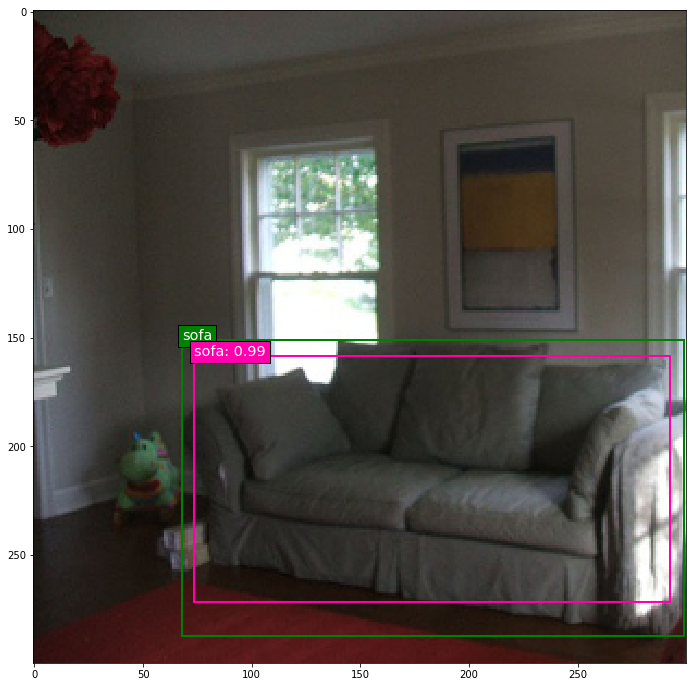

In [308]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(X[1])

current_axis = plt.gca()

for box in y_true[1]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded[1]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})


# INFERENCE

In [230]:
pwd

'/home/purva/Desktop/purva/Single_shot_detector'

In [254]:
pickle_i = open("train_filenames.pickle","rb")
train_filenames = pickle.load(pickle_i)

In [309]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt
img_height = 300
img_width = 300

In [318]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = train_filenames[1121]

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

/home/purva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


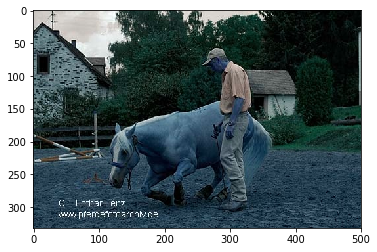

In [319]:
plt.imshow(cv2.imread(img_path))

In [320]:
y_pred = model.predict(input_images)

In [321]:
y_pred_decoded = decode_y(y_pred,
                          confidence_thresh=0.5,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=img_height,
                          img_width=img_width)

In [322]:
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin     ymin   xmax    ymax')
print(y_pred_decoded[0])

Predicted boxes:

    class    conf  xmin     ymin   xmax    ymax
[[ 13.     0.98  68.16 103.81 221.24 270.75]
 [ 13.     0.81  32.28 160.46 242.57 302.22]
 [ 15.     0.98 139.42  54.25 211.59 218.62]
 [ 15.     0.79  98.12  67.13 198.68 243.41]]


In [323]:
classes[13]

'horse'

In [324]:
classes[15]

'person'

##  VISUALIZE THE PREDICTIONS

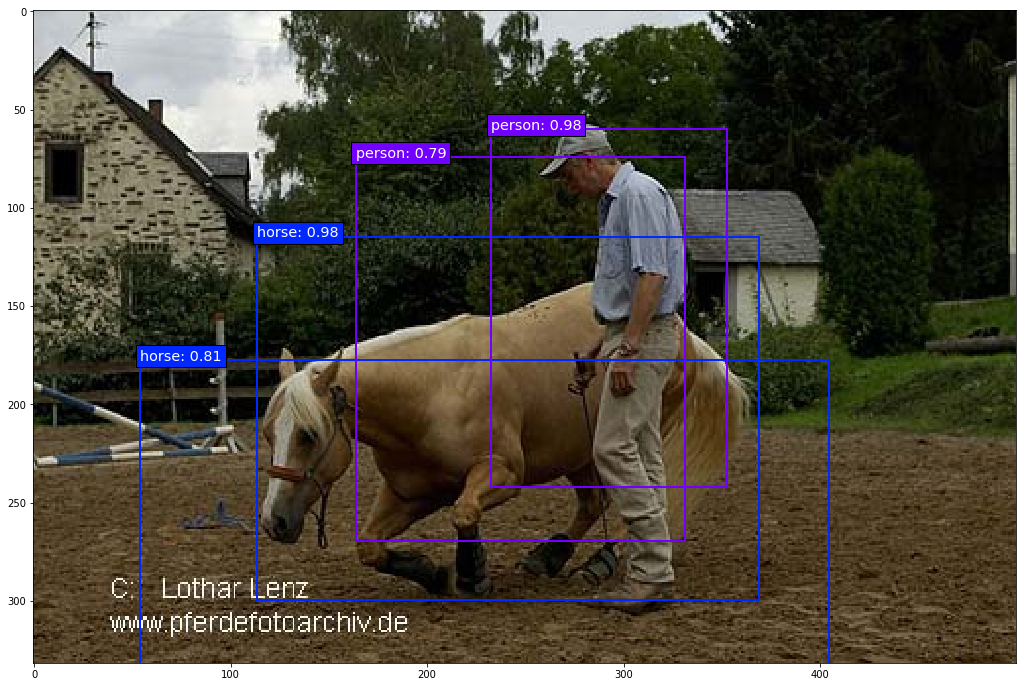

In [326]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()
for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[-4] * orig_images[0].shape[1] / img_width
    ymin = box[-3] * orig_images[0].shape[0] / img_height
    xmax = box[-2] * orig_images[0].shape[1] / img_width
    ymax = box[-1] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

# PREDICTIONS ON THE DATASET

In [327]:
dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])

# TODO: Set the paths to the datasets here.

VOC_2007_test_images_dir = './VOC2007_Test/JPEGImages/'
VOC_2007_test_annotations_dir = './VOC2007_Test/Annotations/'
VOC_2007_test_image_set_filename     = './VOC2007_Test/ImageSets/Main/test.txt'



In [328]:
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset.parse_xml(images_dirs=[VOC_2007_test_images_dir],
                  image_set_filenames=[VOC_2007_test_image_set_filename],
                  annotations_dirs=[VOC_2007_test_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)

In [329]:
generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             train=False,
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             max_crop_and_resize=False,
                             random_pad_and_resize=False,
                             resize=(img_height,img_width))

In [339]:
# Generate a batch and make predictions.

batch_X, batch_filenames, batch_inverse_coord_transform, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ./VOC2007_Test/JPEGImages/009594.jpg

Ground truth boxes:

[[ 20 224 288 334 375]]


In [340]:
y_pred = model.predict(batch_X)

In [341]:
y_pred_decoded = decode_y(y_pred,
                          confidence_thresh=0.5,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=img_height,
                          img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_decoded[i])

Predicted boxes:

    class    conf  xmin    ymin    xmax    ymax
[[ 20.     0.95 126.1  234.48 201.82 297.76]]


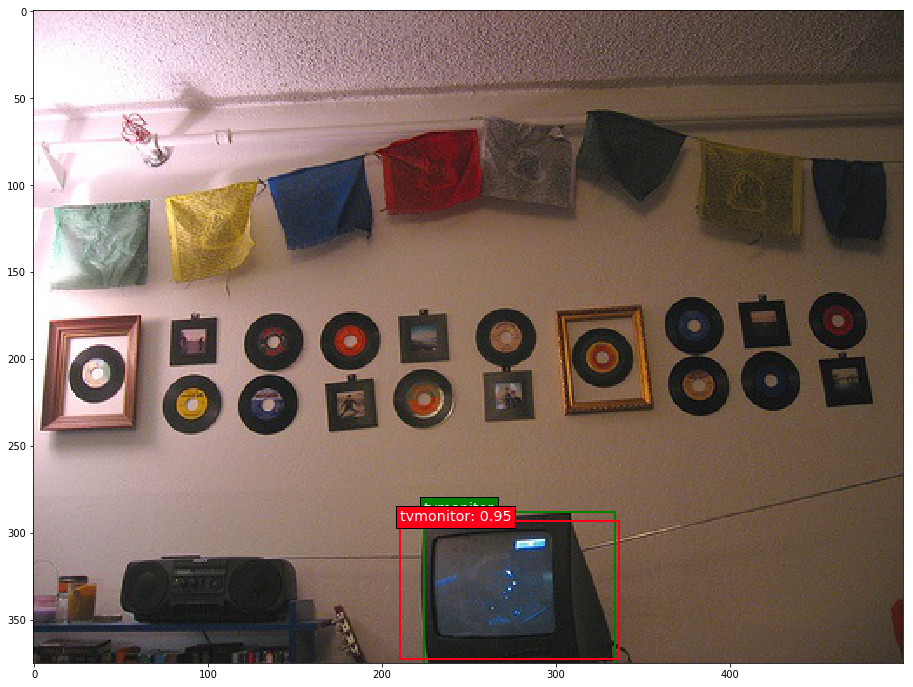

In [342]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for k, box in enumerate(y_pred_decoded[i]):
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = (box[-4] * batch_inverse_coord_transform[i,0,1]) + batch_inverse_coord_transform[i,0,0]
    ymin = (box[-3] * batch_inverse_coord_transform[i,1,1]) + batch_inverse_coord_transform[i,1,0]
    xmax = (box[-2] * batch_inverse_coord_transform[i,2,1]) + batch_inverse_coord_transform[i,2,0]
    ymax = (box[-1] * batch_inverse_coord_transform[i,3,1]) + batch_inverse_coord_transform[i,3,0]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

# EVALUATION

In [353]:
from keras import backend as K
from math import ceil
from tqdm import trange
import sys

from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

In [354]:
def predict_all_to_txt(model,
                       img_height,
                       img_width,
                       batch_generator,
                       batch_size,
                       batch_generator_mode='resize',
                       classes=['background',
                                'aeroplane', 'bicycle', 'bird', 'boat',
                                'bottle', 'bus', 'car', 'cat',
                                'chair', 'cow', 'diningtable', 'dog',
                                'horse', 'motorbike', 'person', 'pottedplant',
                                'sheep', 'sofa', 'train', 'tvmonitor'],
                       out_file_prefix='comp3_det_test_',
                       confidence_thresh=0.01,
                       iou_threshold=0.45,
                       top_k=200,
                       pred_coords='centroids',
                       normalize_coords=True):
    

    if batch_generator_mode == 'resize':
        random_pad_and_resize=False
        resize=(img_height,img_width)
    elif batch_generator_mode == 'pad':
        random_pad_and_resize=(img_height, img_width, 0, 3, 1.0)
        resize=False
    else:
        raise ValueError("Unexpected argument value: `batch_generator_mode` can be either of 'resize' or 'pad', but received '{}'.".format(batch_generator_mode))

    # Set the generator parameters.
    generator = batch_generator.generate(batch_size=batch_size,
                                         shuffle=False,
                                         train=False,
                                         returns={'processed_images', 'image_ids', 'inverse_transform'},
                                         convert_to_3_channels=True,
                                         random_pad_and_resize=random_pad_and_resize,
                                         resize=resize,
                                         limit_boxes=False,
                                         keep_images_without_gt=True)

    # We have to generate a separate results file for each class.
    results = []
    for i in range(1, len(classes)):
        # Create one text file per class and put it in our results list.
        results.append(open('{}{}.txt'.format(out_file_prefix, classes[i]), 'w'))

    # Compute the number of batches to iterate over the entire dataset.
    n_images = batch_generator.get_n_samples()
    print("Number of images in the evaluation dataset: {}".format(n_images))
    n_batches = int(ceil(n_images / batch_size))
    # Loop over all batches.
    tr = trange(n_batches, file=sys.stdout)
    tr.set_description('Producing results file')
    for j in tr:
        # Generate batch.
        batch_X, batch_image_ids, batch_inverse_coord_transform = next(generator)
        # Predict.
        y_pred = model.predict(batch_X)
        # Decode.
        y_pred_decoded = decode_y(y_pred,
                                  confidence_thresh=confidence_thresh,
                                  iou_threshold=iou_threshold,
                                  top_k=top_k,
                                  input_coords=pred_coords,
                                  normalize_coords=normalize_coords,
                                  img_height=img_height,
                                  img_width=img_width)
        # Convert each predicted box into the results format.
        for k, batch_item in enumerate(y_pred_decoded):
            # The box coordinates were predicted for the transformed
            # (resized, cropped, padded, etc.) image. We now have to
            # transform these coordinates back to what they would be
            # in the original images.
            batch_item[:,2:] *= batch_inverse_coord_transform[k,:,1]
            batch_item[:,2:] += batch_inverse_coord_transform[k,:,0]
            for box in batch_item:
                image_id = batch_image_ids[k]
                class_id = int(box[0])
                # Round the box coordinates to reduce the file size.
                confidence = str(round(box[1], 4))
                xmin = str(round(box[2], 1))
                ymin = str(round(box[3], 1))
                xmax = str(round(box[4], 1))
                ymax = str(round(box[5], 1))
                prediction = [image_id, confidence, xmin, ymin, xmax, ymax]
                prediction_txt = ' '.join(prediction) + '\n'
                # Write the predicted box to the text file for its class.
                results[class_id - 1].write(prediction_txt)

    # Close all the files.
    for results_file in results:
        results_file.close()

    print("All results files saved.")

In [355]:
img_height = 300
img_width = 300

In [356]:
dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])
Pascal_VOC_dataset_images_dir = './VOC2007_Test/JPEGImages/'
Pascal_VOC_dataset_annotations_dir = './VOC2007_Test/Annotations/'
Pascal_VOC_dataset_image_set_filename = './VOC2007_Test/ImageSets/Main/test.txt'


In [357]:


dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
                  image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
                  annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

In [358]:
batch_size = 8

In [360]:
predict_all_to_txt(model=model,
                   img_height=img_height,
                   img_width=img_width,
                   batch_generator=dataset,
                   batch_size=batch_size,
                   batch_generator_mode='resize',
                   classes=['background',
                            'aeroplane', 'bicycle', 'bird', 'boat',
                            'bottle', 'bus', 'car', 'cat',
                            'chair', 'cow', 'diningtable', 'dog',
                            'horse', 'motorbike', 'person', 'pottedplant',
                            'sheep', 'sofa', 'train', 'tvmonitor'],
                   out_file_prefix='out_file',
                   confidence_thresh=0.01,
                   iou_threshold=0.45,
                   top_k=200,
                   pred_coords='centroids',
                   normalize_coords=True)

Number of images in the evaluation dataset: 4952
Producing results file: 100%|██████████| 619/619 [02:23<00:00,  4.46it/s]
All results files saved.
